# Á¨¨‰∏âÊ¨°ËÆÄÊõ∏ÊúÉÂ†±Âëä-LDA

ÁµÑÂà•:Á¨¨9ÁµÑ

Date:2024/05/07

# 1.ËºâÂÖ•Áí∞Â¢ÉÂèäÂÆâË£ùÂ•ó‰ª∂

In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# Ë®≠ÂÆöÂúñÁöÑÂ≠óÈ´îÂ§ßÂ∞è
plt.rcParams['font.size'] = 14

# Ë®≠ÂÆö‰∏≠ÊñáÂ≠óÈ´î (ÁÑ°Ê≥ïÈ°ØÁ§∫ÁöÑË©±ÂèØ‰ª•Ë©¶Ë©¶‚ÄòMicrosoft JhengHei‚ÄôÂ≠óÈ´î)
# ‰πüÂèØÂèÉËÄÉÔºöhttps://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
plt.rcParams['axes.unicode_minus']=False

#ÂúñÂûãÁõ∏ÈóúË®≠ÂÆö
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 120

# 2.Ë≥áÊñôÂâçËôïÁêÜ

## 2.1Ë≥áÊñôËíêÈõÜ
Êú¨Â∞èÁµÑËá™Tarflow‰∏ãËºâDacrd‰∏ä4ÂÄãÂÄãÁâàÁöÑÊñáÁ´†Ë≥áÊñôÈõÜÔºå‰∏¶Âü∑Ë°åÁ®ãÂºèÂêàÊàê‰∏ÄÂÄãË≥áÊñôÈõÜÔºåÂÖ±3,598Á≠ÜË≥áÊñô„ÄÇ

ÂÖ∂ÂÖßÂÆπÂåÖÂê´system_id„ÄÅataSource„ÄÅartUrl„ÄÅartDate„ÄÅartTitle„ÄÅartContent„ÄÅboardID(ÊñáÁ´†ÊâÄÂ±¨ÂÄãÁâà)„ÄÅ
commentCount(Ë©ïË´ñÊ¨°Êï∏)„ÄÅdepartment„ÄÅgender„ÄÅschoolÁ≠âÊ¨Ñ‰Ωç„ÄÇ

Data includes:
*   DcardÊñáÁ´† from 2024/03/01 - 2024/03/25
*   Â∞àÁâàÂåÖÂê´‰ª•‰∏ã4ÊùøÔºö
*   Á©øÊê≠Áâà
*   ÊòüÂ∫ßÁâà
*   ÁêÜË≤°Áâà
*   Á†îÁ©∂ÊâÄÁâà

Ë≥áÊñô‰æÜÊ∫ê:https://tarflow.mis.nsysu.edu.tw/login?next=%2Fmain%2F662d88ed73

## 2.2Ë≥áÊñôÂåØÂÖ•ËàáÊ∏ÖÁêÜ

In [3]:
##ËÆÄÂèñË≥áÊñôÈõÜ
dcard_df = pd.read_csv("./2024_study_group9_3/raw_data/dcard_dataset/dcard_set.csv")
dcard_df

system_id dataSource                                             artUrl  \
0             1      Dcard         https://www.dcard.tw/f/dressup/p/255078442   
1             2      Dcard         https://www.dcard.tw/f/dressup/p/255078768   
2             3      Dcard         https://www.dcard.tw/f/dressup/p/255078701   
3             4      Dcard         https://www.dcard.tw/f/dressup/p/255079599   
4             5      Dcard         https://www.dcard.tw/f/dressup/p/255065394   
...         ...        ...                                                ...   
3593        948      Dcard  https://www.dcard.tw/f/graduate_school/p/25486...   
3594        949      Dcard  https://www.dcard.tw/f/graduate_school/p/25486...   
3595        950      Dcard  https://www.dcard.tw/f/graduate_school/p/25486...   
3596        951      Dcard  https://www.dcard.tw/f/graduate_school/p/25484...   
3597        952      Dcard  https://www.dcard.tw/f/graduate_school/p/25486...   

                  artDate                      artTitle  \
0     2024-03-25 16:18:42  #ÂàÜ‰∫´ 150„ÅÆËøëÊúüÊó•Â∏∏Ë£ôË£ùÁ©øÊê≠üå∏üß∏ #Á©øÂá∫ÊàëÁöÑÊó•Á≥ªÈ¢®Ê†º   
1     2024-03-25 16:54:35                      Á©øÂá∫ÊàëÁöÑÊó•Á≥ªÈ¢®Ê†º   
2     2024-03-25 16:45:46                   #Ë©¢Âïè ÁßëÊäÄÊ•≠Â•≥ÁîüÁ©øÊê≠   
3     2024-03-25 21:31:16                  Êâæ‰∏çÂà∞ÊùéÂ§öÊÖßÁöÑÁëú‰ºΩË§≤ÂìÅÁâå   
4     2024-03-24 10:59:45              #ÂàÜ‰∫´ 172ÁöÑÈªëËâ≤Ë°£Ê´Éüêà‚Äç‚¨õ‚ú®   
...                   ...                           ...   
3593  2024-03-03 13:17:05                  Êî∂ÁéãÈÅîÊòåÁ∂ìÊøüÂ≠∏Á†îÁ©∂ÊâÄË¨õÁæ©   
3594  2024-03-03 22:40:19                       Á†îÁ©∂ÊâÄ‰∏äË™≤ÊñπÂºè   
3595  2024-03-03 14:23:21                 ‰∏≠ËààÊáâÁî®Á∂ìÊøüÊâÄÂú®ËÅ∑Â∞àÁè≠Èù¢Ë©¶   
3596  2024-03-02 06:05:29              È´òÈõÑÂ§ßÂ≠∏ ‰∫ûÂ§™Â∑•ÂïÜÂ≠∏Á≥ª ÊïôÊéàË´ãÁõä   
3597  2024-03-03 14:04:14                       Á†îÁ©∂ÊâÄÈÅ∏ÊìáË´ãÁõä   

                                             artContent          boardID  \
0     https://megapx.dcard.tw/v1/images/e6ee0893-3a7...          dressup   
1     \È∫µÂåÖË∂Ö‰∫∫/\nÂõ†ÁÇ∫Êú¨Ë∫´Èï∑Áõ∏ÁÑ°ÂÑ™Âã¢\nÊâÄ‰ª•Ê±∫ÂÆöÁî®È∫µÂåÖË∂Ö‰∫∫ÁöÑÂûãÊÖãÂá∫Â†¥ü§©‚ú®\nÁ™ÆË∂Ö‰∫∫Êú¨‰∫∫ÁúüÁöÑÂ•ΩÊÉ≥...          dressup   
2     ÂéüÊú¨Âú®Êñ∞ÂâµÂÖ¨Âè∏‰∏äÁè≠ÔºåÂπ≥Â∏∏‰∏äÁè≠Á©øÊê≠Ê≤íÂú®ÁÆ°\nÁ©øÁü≠Ë§≤„ÄÅÈú≤ËÇöËáç„ÄÅÊà¥Â∏ΩÂ≠ê ÈÉΩÂèØ‰ª•\n\n‰ΩÜ‰∏ãÈÄ±ËΩâËÅ∑Êèõ...          dressup   
3                                                   NaN          dressup   
4     https://megapx.dcard.tw/v1/images/61f1cb51-fb7...          dressup   
...                                                 ...              ...   
3593                            ÊÉ≥Ë¶ÅËá™ËÆÄ ÊúâË¨õÁæ©„ÄÅÂ∞èËÄÉËÄÉÂç∑ÁöÑË©±ÊúÄÂ•Ω\nÈùûÂ∏∏ÊÑüË¨ù  graduate_school   
3594  Ë´ãÊïô‰∏Ä‰∏ãÂêÑ‰Ωç\nÂ§ßÂÆ∂Âî∏Á†îÁ©∂ÊâÄÁöÑ‰∏äË™≤ÊñπÂºèÔºü\nÊàëÊòØÁ¨¨‰∏ÄÂ†ÇË™≤ÊïôÊéàÊúÉË¨õ‰∏Ä‰∏ãË™≤Á®ãÂ§ßÁ∂±„ÄÅÂ†±ÂëäÂÖßÂÆπ„ÄÅÂàÜÁµÑ...  graduate_school   
3595  ÂêÑ‰ΩçÂ•ΩÔºÅ\nÊú¨‰∫∫ÊúâÂπ∏ÈÄöÈÅé‰∏≠ËààÊáâÁ∂ìÂú®ËÅ∑Â∞àÁè≠ÁöÑÁ¨¨‰∏ÄÈöéÊÆµÂØ©Êü•\nÊÉ≥Ë´ãÂïèÂêÑ‰ΩçÈù¢Ë©¶ÊñπÈù¢Èô§‰∫ÜËá™Êàë‰ªãÁ¥πÂ§ñÊïô...  graduate_school   
3596  ‰ªäÂπ¥ËÄÉË©¶Êú¨‰∫∫Ê≠£ÂèñÔºåÊÉ≥Ë´ãÁõäÊúâÈóúÈ´òÂ§ß‰∫ûÂ§™Á≥ªÁöÑÊïôÊéà\n\nÁõÆÂâçÊúâËààË∂£ÁöÑÊïôÊéàÊúâÔºö\n1.Ë®±ÂçöÁøî ÊïôÊéà...  graduate_school   
3597  ÊÉ≥ÂÖàË™™ÂÄãÂâçË®ÄÔºåÂ∞çÊ≤íÈåØÊàëÁöÑÂ≠∏Ê•≠Â∞±ÊòØËµ∞„Ñé„ÑéË∑ØÁ∑öÈÅ∏ÁöÑÁ≥ªÊâÄÂæàÂÜ∑ÈñÄÔºåÁà¨ÈÅéÊñáÂ∏∏Â∏∏ÁúãÂà∞Êúâ‰∫∫ÁïôË®ÄÊúâÈóúÁîüÁßëÁöÑÂ∞±...  graduate_school   

      commentCount     department gender  school  
0               40      ruuuuu___      F     „Åæ„Çãüêª  
1               21        clumnar      F    ÈòøËÉñÈ∫µ‰∫∫  
2              352            NaN      F  ÂúãÁ´ãÊîøÊ≤ªÂ§ßÂ≠∏  
3                3      softcindy      F  Ë±ÜËÖêÂøÉËÄÅË≤ìÂ•¥  
4               24         bea.16      F     172  
...            ...            ...    ...     ...  
3593             5            NaN      M  ÂúãÁ´ãËá∫ÂåóÂ§ßÂ≠∏  
3594            11  mentalillness      F      ÂêìËÅä  
3595             0  volleyball123      M    ÁôΩÂ∫ïËôéÊñë  
3596             1            NaN      M  ÂúãÁ´ãËÅØÂêàÂ§ßÂ≠∏  
3597           

In [4]:
#Ë≥áÊñôÈõÜ‰∏≠ÂèØËÉΩÊúâÁ≠âÊñº0ÊàñÊòØNaNÁöÑÂÄºÔºåÊïÖÁî®Á¥¢ÂºïÈÅ∏Êìá‰∏çÁ≠âÊñº0‰∏î‰∏çÊòØNaNÁöÑÂÄºÔºåÊé•Ëëó‰ΩøÁî®dropna()ÊñπÊ≥ïÂà™Èô§NaNÁöÑË°å
dcard_df = dcard_df[(dcard_df !=0) & (dcard_df.notna())].dropna()
dcard_df

system_id dataSource                                             artUrl  \
0             1      Dcard         https://www.dcard.tw/f/dressup/p/255078442   
1             2      Dcard         https://www.dcard.tw/f/dressup/p/255078768   
4             5      Dcard         https://www.dcard.tw/f/dressup/p/255065394   
6             7      Dcard         https://www.dcard.tw/f/dressup/p/255047494   
7             8      Dcard         https://www.dcard.tw/f/dressup/p/255065466   
...         ...        ...                                                ...   
3588        943      Dcard  https://www.dcard.tw/f/graduate_school/p/25483...   
3590        945      Dcard  https://www.dcard.tw/f/graduate_school/p/25485...   
3591        946      Dcard  https://www.dcard.tw/f/graduate_school/p/25483...   
3592        947      Dcard  https://www.dcard.tw/f/graduate_school/p/25485...   
3594        949      Dcard  https://www.dcard.tw/f/graduate_school/p/25486...   

                  artDate                                     artTitle  \
0     2024-03-25 16:18:42                 #ÂàÜ‰∫´ 150„ÅÆËøëÊúüÊó•Â∏∏Ë£ôË£ùÁ©øÊê≠üå∏üß∏ #Á©øÂá∫ÊàëÁöÑÊó•Á≥ªÈ¢®Ê†º   
1     2024-03-25 16:54:35                                     Á©øÂá∫ÊàëÁöÑÊó•Á≥ªÈ¢®Ê†º   
4     2024-03-24 10:59:45                             #ÂàÜ‰∫´ 172ÁöÑÈªëËâ≤Ë°£Ê´Éüêà‚Äç‚¨õ‚ú®   
6     2024-03-22 10:00:10  #ÂàÜ‰∫´ Â∞èÈöªÂ•≥Â≠©ùü≠ùü±ùü¨ùó∞ùó∫ üçØËøëÊúüÊúÄÊÑõÁöÑùüØ‰ª∂Êó•ÁâåÊ¥ãË£ùÂàÜ‰∫´(¬¥·µíÃ¥Ã∂Ã∑Ã§‚àÄ·µíÃ¥Ã∂Ã∑Ã§)üíõ   
7     2024-03-24 11:08:57                           #ÂàÜ‰∫´ 161ÊåëÊà∞ÂèØÁîúÂèØÈπΩ4Á®ÆÁ©øÊê≠üéÄ   
...                   ...                                          ...   
3588  2024-03-01 12:00:12                                ÈùûÊú¨ÁßëÁ≥ªÊ∫ñÂÇôÊ©üÊ¢∞Á¢©Â£´Âú®ËÅ∑Áè≠   
3590  2024-03-03 11:16:03                                   ÊòØÂê¶ÁπºÁ∫åËÆÄÁ§æÂ∑•Á†îÁ©∂ÊâÄ   
3591  2024-03-01 11:01:16                                   Â§ßÁ¢©vsÈ´òÈªû ÁÆ°ÁêÜÂ≠∏   
3592  2024-03-03 13:10:51                               ÔºªÂàÜ‰∫´ÔºΩ113Âè∞Â§ßÊáâÊï∏ÊâÄÊé®ÁîÑ   
3594  2024-03-03 22:40:19                                      Á†îÁ©∂ÊâÄ‰∏äË™≤ÊñπÂºè   

                                             artContent          boardID  \
0     https://megapx.dcard.tw/v1/images/e6ee0893-3a7...          dressup   
1     \È∫µÂåÖË∂Ö‰∫∫/\nÂõ†ÁÇ∫Êú¨Ë∫´Èï∑Áõ∏ÁÑ°ÂÑ™Âã¢\nÊâÄ‰ª•Ê±∫ÂÆöÁî®È∫µÂåÖË∂Ö‰∫∫ÁöÑÂûãÊÖãÂá∫Â†¥ü§©‚ú®\nÁ™ÆË∂Ö‰∫∫Êú¨‰∫∫ÁúüÁöÑÂ•ΩÊÉ≥...          dressup   
4     https://megapx.dcard.tw/v1/images/61f1cb51-fb7...          dressup   
6     https://megapx.dcard.tw/v1/images/dbbc7b1a-dec...          dressup   
7     ÂìàÂõâÂ§ßÂÆ∂Â•ΩÊàëÊòØËçâËéìÂ•∂Êòîüçì\nÂπ≥Â∏∏ÈÉΩÂú®ÁæéÂ¶ùÁâàÂá∫Ê≤íÁöÑÊàë\n‰ªäÂ§©Ë¶Å‰æÜÂàÜ‰∫´4Â•óÂèØÁîúÂèØÈππÁöÑÁ©øÊê≠üôà\nÊúâ...          dressup   
...                                                 ...              ...   
3588  Â§ßÂÆ∂Â•Ω\n\nË´ãÂïèÈùûÊú¨ÁßëÁ≥ªÊÉ≥ËÆÄÊ©üÊ¢∞Á¢©Â£´Âú®ËÅ∑Áè≠\n\nÂ∑•‰ΩúÊòØÊ©üÊßãÂ∑•Á®ãÂ∏´ÊúâÊ©üÊúÉÈÄ≤Ê©üÊ¢∞ÊâÄÂóé ?\n...  graduate_school   
3590  ‰∏çÁü•ÈÅìÁôºÈÄôÁâàÂ∞ç‰∏çÂ∞ç\n‰ΩÜÊòØÈÇÑÊòØÊÉ≥ÂïèÂïèÂ∞±ËÆÄÈÅéÁ†îÁ©∂ÊâÄÁöÑÂêÑ‰Ωç\nÊòØÂê¶Ë©≤ÁπºÁ∫åÂ∞±ËÆÄÁ§æÂ∑•ÁöÑÁ†îÁ©∂ÊâÄÔºü\n\...  graduate_school   
3591  ÁõÆÂâçÂú®ËÄÉÊÖÆÂ†±‰ºÅÁ†îÊâÄ Ë©¶ËÅΩÈÅéÂÖ©ÂÆ∂\nÁÆ°ÁêÜÂ≠∏Â§ßÁ¢©Ë∂ôËÄÅÂ∏´ÁöÑÈÇ£Â†ÇË©¶ËÅΩÂÆåÂÖ®Ê≤íÊùøÊõ∏ÔºàÁ∑ö‰∏äË©¶ËÅΩÂè™ÊúâÈÇ£Â†ÇÔºâÊâÄ...  graduate_school   
3592  Êé®ÁîÑÂàÜ‰∏âÊ≠•È©üÔºåÂ∞±‰æùÈ†ÜÂ∫è‰æÜË™™Ôºö\n\n‰∏Ä„ÄÅ‰∏äÂÇ≥Ë≥áÊñôÔºö\nÁ∞°ÂñÆ‰æÜË™™Â∞±ÊòØÊää‰∏Ä‰∫õÂ§ßÂ≠∏ÁöÑË±êÂäüÂÅâÊ•≠‰∏äÂÇ≥Ôºå...  graduate_school   
3594  Ë´ãÊïô‰∏Ä‰∏ãÂêÑ‰Ωç\nÂ§ßÂÆ∂Âî∏Á†îÁ©∂ÊâÄÁöÑ‰∏äË™≤ÊñπÂºèÔºü\nÊàëÊòØÁ¨¨‰∏ÄÂ†ÇË™≤ÊïôÊéàÊúÉË¨õ‰∏Ä‰∏ãË™≤Á®ãÂ§ßÁ∂±„ÄÅÂ†±ÂëäÂÖßÂÆπ„ÄÅÂàÜÁµÑ...  graduate_school   

      commentCount     department gender    school  
0             40.0      ruuuuu___      F       „Åæ„Çãüêª  
1             21.0        clumnar      F      ÈòøËÉñÈ∫µ‰∫∫  
4             24.0         bea.16      F       172  
6             75.0     ningggg131      F   „Éã„É≥¬∑Ning  
7              5.0       susu.310      F     ËçâËéìÂ•∂Êòîüçì  
...            ...            ...    ...       ...

In [5]:
# ÁßªÈô§Á∂≤ÂùÄÊ†ºÂºè
# Âè™Áïô‰∏ã‰∏≠ÊñáÂ≠ó
dcard_df["artContent"] = dcard_df["artContent"].str.replace("(http|https)://.*", "", regex=True)
dcard_df["artTitle"] = dcard_df["artTitle"].str.replace("(http|https)://.*", "", regex=True)
dcard_df["artContent"] = dcard_df["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
dcard_df["artTitle"] = dcard_df["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
dcard_df['content'] = dcard_df['artContent']
dcard_df['artCatagory'] = dcard_df['boardID']

dcard_df = dcard_df.loc[:,["content", "artUrl", "artCatagory", 'artDate']] #Áïô‰∏ãÊñáÁ´†ÂÖßÂÆπ„ÄÅÊñáÁ´†ÈÄ£ÁµêËàáÊñáÁ´†Á®ÆÈ°û
dcard_df.head(3)

content  \
0  Â§ßÂÆ∂Â•ΩÊàëÊòØË∫´È´òÈ´îÈáçÂæàÂñúÊ≠°Ë£ôË£ùÊâÄ‰ª•Ë°£Ê´ÉË£°Âπæ‰πéÊâæ‰∏çÂà∞Ë§≤Â≠êÁÖßÁâáÈÉΩÊòØÂá∫ÂéªÁé©ÊôÇÊãçÁöÑ‰∏çÈÅéÊòØÂá∫ÈÅäÈ†Ü‰æøÊãçÁöÑ‰∏ç...   
1  È∫µÂåÖË∂Ö‰∫∫Âõ†ÁÇ∫Êú¨Ë∫´Èï∑Áõ∏ÁÑ°ÂÑ™Âã¢ÊâÄ‰ª•Ê±∫ÂÆöÁî®È∫µÂåÖË∂Ö‰∫∫ÁöÑÂûãÊÖãÂá∫Â†¥Á™ÆË∂Ö‰∫∫Êú¨‰∫∫ÁúüÁöÑÂ•ΩÊÉ≥Áç≤ÂæóË≥ºÁâ©ÈáëÁ¨¨‰∏ÄÂ•óÊòØ‰ºë...   
4  ÂìàÂõâÂ§ßÂÆ∂Â•Ω‰πÖ‰∏çË¶ãÁ´üÁÑ∂Èöî‰∫ÜÂÖ©Âπ¥È¢®Ê†ºË∑ü‰ª•ÂâçÂ•ΩÂÉèËΩâËÆäË†ªÂ§ßÁöÑÁèæÂú®ÈÉΩÁ©øÊ∑±Ëâ≤Á≥ªÁÇ∫‰∏ªÁ∞°ÂñÆÂèàÊê≠ÂïäË∫´È´òÈ´îÈáçÈÇÑÊòØ...   

                                       artUrl artCatagory              artDate  
0  https://www.dcard.tw/f/dressup/p/255078442     dressup  2024-03-25 16:18:42  
1  https://www.dcard.tw/f/dressup/p/255078768     dressup  2024-03-25 16:54:35  
4  https://www.dcard.tw/f/dressup/p/255065394     dressup  2024-03-24 10:59:45

In [6]:
#Â∞áartCatagoryÂæûËã±ÊñáËΩâ‰∏≠Êñá
dcard_df["artCatagory"] = dcard_df["artCatagory"].replace('dressup','Á©øÊê≠')
dcard_df["artCatagory"] = dcard_df["artCatagory"].replace('horoscopes','ÊòüÂ∫ß')
dcard_df["artCatagory"] = dcard_df["artCatagory"].replace('money','ÁêÜË≤°')
dcard_df["artCatagory"] = dcard_df["artCatagory"].replace('graduate_school','Á†îÁ©∂ÊâÄ')

In [7]:
dcard_df["artCatagory"]

0        Á©øÊê≠
1        Á©øÊê≠
4        Á©øÊê≠
6        Á©øÊê≠
7        Á©øÊê≠
       ... 
3588    Á†îÁ©∂ÊâÄ
3590    Á†îÁ©∂ÊâÄ
3591    Á†îÁ©∂ÊâÄ
3592    Á†îÁ©∂ÊâÄ
3594    Á†îÁ©∂ÊâÄ
Name: artCatagory, Length: 1249, dtype: object

## 2.3Ë≥áÊñôÂÅúÁî®Ë©ûËàáÊñ∑Ë©û‰ΩøÁî®

In [8]:
# Ë®≠ÂÆöÁπÅÈ´î‰∏≠ÊñáË©ûÂ∫´
jieba.set_dictionary("./2024_study_group9_3/dict/dict.txt.big")

# Êñ∞Â¢ûstopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tagsÊâçÊúÉ‰ΩúÁî®
with open("./2024_study_group9_3/dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# Ë®≠ÂÆöÊñ∑Ë©û function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # ÁØ©ÈÅ∏ÊéâÂÅúÁî®Â≠óËàáÂ≠óÂÖÉÊï∏Â§ßÊñº1ÁöÑË©ûÂΩô
    return seg_list


# dcard_df = pd.DataFrame(dcard_df['content'].astype(str))
# dcard_df = dcard_df.dropna(axis=1)
dcard_df["words"] = dcard_df['content'].apply(getToken)
dcard_df.head()

Building prefix dict from /Users/billyke/2024_study_group9_3/dict/dict.txt.big ...
2024-05-05 23:10:23,325 : DEBUG : Building prefix dict from /Users/billyke/2024_study_group9_3/dict/dict.txt.big ...
Dumping model to file cache /var/folders/ng/25l3_vws2cl593j20n75bcy00000gn/T/jieba.ub817e87c4f44254fcc0f9ec94260f77a.cache
2024-05-05 23:10:23,889 : DEBUG : Dumping model to file cache /var/folders/ng/25l3_vws2cl593j20n75bcy00000gn/T/jieba.ub817e87c4f44254fcc0f9ec94260f77a.cache
Loading model cost 0.619 seconds.
2024-05-05 23:10:23,945 : DEBUG : Loading model cost 0.619 seconds.
Prefix dict has been built successfully.
2024-05-05 23:10:23,946 : DEBUG : Prefix dict has been built successfully.


content  \
0  Â§ßÂÆ∂Â•ΩÊàëÊòØË∫´È´òÈ´îÈáçÂæàÂñúÊ≠°Ë£ôË£ùÊâÄ‰ª•Ë°£Ê´ÉË£°Âπæ‰πéÊâæ‰∏çÂà∞Ë§≤Â≠êÁÖßÁâáÈÉΩÊòØÂá∫ÂéªÁé©ÊôÇÊãçÁöÑ‰∏çÈÅéÊòØÂá∫ÈÅäÈ†Ü‰æøÊãçÁöÑ‰∏ç...   
1  È∫µÂåÖË∂Ö‰∫∫Âõ†ÁÇ∫Êú¨Ë∫´Èï∑Áõ∏ÁÑ°ÂÑ™Âã¢ÊâÄ‰ª•Ê±∫ÂÆöÁî®È∫µÂåÖË∂Ö‰∫∫ÁöÑÂûãÊÖãÂá∫Â†¥Á™ÆË∂Ö‰∫∫Êú¨‰∫∫ÁúüÁöÑÂ•ΩÊÉ≥Áç≤ÂæóË≥ºÁâ©ÈáëÁ¨¨‰∏ÄÂ•óÊòØ‰ºë...   
4  ÂìàÂõâÂ§ßÂÆ∂Â•Ω‰πÖ‰∏çË¶ãÁ´üÁÑ∂Èöî‰∫ÜÂÖ©Âπ¥È¢®Ê†ºË∑ü‰ª•ÂâçÂ•ΩÂÉèËΩâËÆäË†ªÂ§ßÁöÑÁèæÂú®ÈÉΩÁ©øÊ∑±Ëâ≤Á≥ªÁÇ∫‰∏ªÁ∞°ÂñÆÂèàÊê≠ÂïäË∫´È´òÈ´îÈáçÈÇÑÊòØ...   
6  Âó®Âó®ÊàëÊòØÂØßÈÄôÊ¨°ÊÉ≥‰æÜÂíåÂ§ßÂÆ∂ÂàÜ‰∫´ÊàëÊúÄËøëÊñ∞ÂÖ•ÊâãÁöÑÊó•ÁâåÊ¥ãË£ùÂÄëÊûúÁÑ∂Â∞èÈöªÂ•≥Â≠©Ë≤∑Êó•ÁâåÂ∞±ÊòØ‰∏çÊúÉÈåØÈï∑Â∫¶ÈÉΩÊúÉÂæàÂâõ...   
7  ÂìàÂõâÂ§ßÂÆ∂Â•ΩÊàëÊòØËçâËéìÂ•∂ÊòîÂπ≥Â∏∏ÈÉΩÂú®ÁæéÂ¶ùÁâàÂá∫Ê≤íÁöÑÊàë‰ªäÂ§©Ë¶Å‰æÜÂàÜ‰∫´Â•óÂèØÁîúÂèØÈππÁöÑÁ©øÊê≠ÊúâËààË∂£ÁöÑÂ∞±‰∏ÄËµ∑Áúã‰∏ãÂéª...   

                                       artUrl artCatagory  \
0  https://www.dcard.tw/f/dressup/p/255078442          Á©øÊê≠   
1  https://www.dcard.tw/f/dressup/p/255078768          Á©øÊê≠   
4  https://www.dcard.tw/f/dressup/p/255065394          Á©øÊê≠   
6  https://www.dcard.tw/f/dressup/p/255047494          Á©øÊê≠   
7  https://www.dcard.tw/f/dressup/p/255065466          Á©øÊê≠   

               artDate                                              words  
0  2024-03-25 16:18:42  [Ë∫´È´òÈ´îÈáç, ÂñúÊ≠°, Ë£ôË£ù, Ë°£Ê´É, ‰∏çÂà∞, Ë§≤Â≠ê, ÁÖßÁâá, Âá∫ÂéªÁé©, Âá∫ÈÅä, È†Ü‰æø, Â∞àÊ•≠...  
1  2024-03-25 16:54:35  [Ë∂Ö‰∫∫, Èï∑Áõ∏, ÂÑ™Âã¢, Ê±∫ÂÆö, Ë∂Ö‰∫∫, ÂûãÊÖã, Âá∫Â†¥, Ë∂Ö‰∫∫, ÁúüÁöÑ, Áç≤Âæó, Ë≥ºÁâ©, Á¨¨...  
4  2024-03-24 10:59:45  [ÂìàÂõâ, Â•Ω‰πÖ‰∏çË¶ã, ÂÖ©Âπ¥, È¢®Ê†º, ‰ª•Ââç, Â•ΩÂÉè, ËΩâËÆä, Ë†ªÂ§ß, ÁèæÂú®, Ê∑±Ëâ≤, Á≥ªÁÇ∫,...  
6  2024-03-22 10:00:10  [ÊòØÂØß, ÈÄôÊ¨°, ÊÉ≥‰æÜ, ÂàÜ‰∫´, ÊúÄËøë, ÂÖ•Êâã, Êó•Áâå, Ê¥ãË£ù, Â•≥Â≠©, Ë≤∑Êó•Áâå, ‰∏çÊúÉÈåØ,...  
7  2024-03-24 11:08:57  [ÂìàÂõâ, ËçâËéì, Â•∂Êòî, Âπ≥Â∏∏, ÁæéÂ¶ùÁâà, Âá∫Ê≤í, ‰ªäÂ§©, Ë¶Å‰æÜ, ÂàÜ‰∫´, ËààË∂£, ‰∏ÄËµ∑, ...

In [9]:
#ÂàóÂá∫Ê≠§Ë≥áÊñôÈõÜÂåÖÂê´DcardÂì™ÂπæÂÄãÂÄãÁâà
dcard_df['artCatagory'].unique()

array(['Á©øÊê≠', 'ÊòüÂ∫ß', 'ÁêÜË≤°', 'Á†îÁ©∂ÊâÄ'], dtype=object)

È°ØÁ§∫‰∏çÂêå‰∏ªÈ°åÂá∫ÁèæÊúÄÂ∏∏Âá∫ÁèæÁöÑË©û

In [10]:
## ÂÆöÁæ©‰∏ªÈ°å(Á©øÊê≠)
dcard_df_dressup = dcard_df.loc[dcard_df['artCatagory'] == 'Á©øÊê≠',:]['words'].explode().value_counts().head(100)
dcard_df_dressup.index

Index(['ÂñúÊ≠°', 'ÂàÜ‰∫´', 'Êê≠ÈÖç', '‰∏äË°£', 'Â§ñÂ•ó', 'ÁúüÁöÑ', 'ÈÄô‰ª∂', 'ÊØîËºÉ', 'Ë¶∫Âæó', 'ÈûãÂ≠ê', 'Ë°£Êúç', 'Ê¥ãË£ù',
       'ËÉåÂøÉ', 'ÊÑüË¶∫', 'Ë§≤Â≠ê', 'Ë£ôÂ≠ê', 'ÈÅ©Âêà', 'Â•ΩÁúã', '‰∏Ä‰ª∂', 'ÈÄôÊ¨°', 'ÈáùÁπî', 'Ë®≠Ë®à', 'È°èËâ≤', 'ÂèØÊÑõ',
       'ÁôΩËâ≤', 'Ë•ØË°´', 'ÊúÄËøë', 'ÈÄôÂ•ó', 'È¢®Ê†º', 'ÈªëËâ≤', '‰∏ÄÈªû', 'ÂåÖÂåÖ', 'ÊùêË≥™', 'Êï¥È´î', 'ÊúâÈªû', 'Èï∑Ë£ô',
       'ÂñÆÂìÅ', 'Â∏åÊúõ', 'ÁúãÂà∞', 'Áü•ÈÅì', 'Ë∂ÖÁ¥ö', '‰ª•‰∏ä', 'Ëù¶ÁöÆ', '‰∏ÄÂ•ó', '‰ªäÂ§©', 'ÊØõË°£', 'Ê∑òÂØ∂', 'Â§©Ê∞£',
       'Ë¨ùË¨ù', 'ÊúãÂèã', 'Á∞°ÂñÆ', 'Ë£°Èù¢', 'Ê≠°Ëøé', '‰∏Ä‰∏ã', 'Â∏ΩÂ≠ê', 'Êó•Êú¨', 'Êó•Â∏∏', 'ÁâàÂûã', 'ÈÅ∏Êìá', 'ÊúÄÂæå',
       '‰∏Ä‰∫õ', 'Á¨¨‰∏ÄÂ•ó', 'Áâõ‰ªî', 'ÈüìÂúã', 'Êó•Á≥ª', 'ÁÅ∞Ëâ≤', '‰∏ÄËµ∑', 'ÁâπÂà•', 'ÁïôË®Ä', 'Áâõ‰ªîË§≤', 'ÊáâË©≤',
       'Áõ¥Êé•', 'Êé®Ëñ¶', 'Ë≥ºÂÖ•', 'ÁôºÁèæ', 'Âá∫ÈñÄ', 'ËïæÁµ≤', 'ÁÖßÁâá', '‰øùÊöñ', 'ÈÄèËÜö', 'Êò•Â§©', 'ÊãçÁÖß', 'ÁΩ©Ë°´',
       'Á≤âËâ≤', '‰∏ãÊ¨°', 'È´òÈ†ò', 'ÈÄ†Âûã', 'ÂòóË©¶', 'È†ÖÈçä', '‰∏ÄÁõ¥', '‰πãÂâç', 'Á¨¨‰∫åÂ•ó', 'ËóçËâ≤', 'ËøëÊ

In [11]:
## ÂàóÂá∫‰∏ªÈ°åÂ≠óË©û(ÊòüÂ∫ß)
dcard_df_horoscopes = dcard_df.loc[dcard_df['artCatagory'] == 'ÊòüÂ∫ß',:]['words'].explode().value_counts().head(200)
pprint(" ".join(dcard_df_horoscopes.index))

('ÊúãÂèã ÂñúÊ≠° Ë¶∫Âæó ÊÑüÊÉÖ Áü•ÈÅì ÊòüÂ∫ß ÁúüÁöÑ ‰∏ÄËµ∑ Â∑•‰Ωú Â∞çÊñπ ‰∏ªÂãï ÂïèÈ°å ‰∫ãÊÉÖ ÊúÄËøë ÊØîËºÉ ÁèæÂú® ËôïÂ•≥ ÊÑüË¶∫ Ë™çË≠ò ÊñπÈù¢ ËÅäÂ§© ÈúÄË¶Å Ë®äÊÅØ ÊôÇÈñì Â•≥Áîü '
 'ÊúâÈªû Ê∞¥Áì∂ ‰∏Ä‰∏ã ‰∏ÄÁõ¥ ÊÉ≥Ë¶Å ‰πãÂâç ÈÅáÂà∞ ‰πãÂæå ÂÆπÊòì Áõ∏Ëôï ÈáëÁâõ ËôïÂ•≥Â∫ß ÊõñÊòß ‰∏ÄÈªû ‰∏Ä‰∫õ Â∑≤Á∂ì ÈõôÈ≠ö Áõ¥Êé• ÁõÆÂâç ÊáâË©≤ ÊÉ≥Ê≥ï ‰∫§ÂæÄ Èóú‰øÇ ÁúãÂà∞ Â•ΩÂ•Ω '
 'ÂÖ©ÂÄã ‰∏çÊÉ≥ Á™ÅÁÑ∂ ‰∏ÄÊ¨° ÊúÄÂæå ÁçÖÂ≠ê ÂëäÁôΩ Ë¶ãÈù¢ ÁúüÊÑõ ÁîüÊ¥ª ÂëäË®¥ ÈáëÁâõÂ∫ß ÂàÜÊâã Â•ΩÊÑü ÂàÜ‰∫´ ‰∏ÄÂÆö ÈóúÂøÉ ÁôºÁèæ Â•ΩÂÉè Ë´ãÂïè Â§©Ë†ç Â§©Ë†çÂ∫ß Ê©üÊúÉ ÂêµÊû∂ Â∞çË±° '
 'ÊØèÂ§© ‰æÜË™™ Â∏åÊúõ ‰∏ÄÈÄ± ÈõôÈ≠öÂ∫ß Â∞ÑÊâãÂ∫ß Ë©±È°å ÁâπÂà• ‰ªäÂ§© Áâ°Áæä È°òÊÑè ÊñπÂºè Ê∫ùÈÄö ÈñãÂøÉ ÈÅ©Âêà Â∞ÑÊâã ÊúâÊ≤íÊúâ ÊÑüÂèó ÁÑ°Ê≥ï ÈõôÂ≠ê ‰∏çÂ•Ω ÈõªË©± ÊÉÖÁ∑í ÊàëÊúÉ '
 'ÂãáÊï¢ Â§©Áß§ ÁúãÁúã Â∑®Ëüπ ÊúâÊôÇÂÄô Áµ¶Êàë Ëæ¶Ê≥ï Á∏ΩÊòØ Âú∞Êñπ ÊÑèÊÄù ÂπæÂ§© ËÆäÂæó Èù¢Â∞ç ÁîüÊ∞£ Ê∞¥Áì∂Â∫ß ËÆäÊàê ÁπºÁ∫å ‰∫ãÊ•≠ ÂÆåÂÖ® ‰∫ÜËß£ È≠îÁæØ Ê≥®ÊÑè Áî∑Âèã Ë™™Ë©± ÈÄôÊòØ '
 'ÂàÜÈñã ÁçÖÂ≠êÂ∫ß ÁôºÁîü ËÅØÁµ° Ë∂ÖÁ¥ö Ë≠¨Â¶ÇË™™ ÊãíÁµï ÈõôÂ≠êÂ∫ß ‰∏çÁî® ÂøÉË£° ÁßÅË®ä 

In [12]:
## ÂàóÂá∫‰∏ªÈ°åÂ≠óË©û(ÁêÜË≤°)
dcard_df_money = dcard_df.loc[dcard_df['artCatagory'] == 'ÁêÜË≤°',:]['words'].explode().value_counts().head(200)
pprint(" ".join(dcard_df_money.index))

('ÊäïË≥á ÁõÆÂâç Âà©Áéá ËÇ°Á•® Ë≤∏Ê¨æ ÊØîËºÉ ÁèæÂú® ÊØîÁâπ ÈäÄË°å Ë≥áÈáë ÈúÄË¶Å Ë´ãÂïè ÂÖ¨Âè∏ Âà©ÊÅØ Â†±ÈÖ¨ ÂÉπÊ†º ÊôÇÈñì ÂÆöÊúü Áü•ÈÅì ÁèæÈáë Ë≥áÁî¢ ÂàÜ‰∫´ ‰ø°Ë≤∏ Â∏ÇÂ†¥ Áî≥Ë´ã '
 'ÂïèÈ°å ËÇ°ÊÅØ ÁêÜË≤° ÂÆöÈ°ç ÈáëÈ°ç ÊúÄËøë Âª∫Ë≠∞ ÊØèÂÄã Â∑≤Á∂ì Â∑•‰Ωú Ë¶∫Âæó ‰ΩøÁî® Ë¨ùË¨ù Áõ¥Êé• ÊáâË©≤ ÊåÅÁ∫å ‰ª•‰∏ä ‰∏Ä‰∏ã Â∏åÊúõ ÁæéÂÇµ ‰∏Ä‰∫õ ‰πãÂæå ÈÖçÊÅØ Â∏≥Êà∂ ‰ø°Áî®Âç° '
 'ÁúüÁöÑ È¢®Èö™ ÊäïÂÖ• ‰∏ÄÂπ¥ Á≠ñÁï• ÁúãÂà∞ ÈÅ∏Êìá ÂúãÊ≥∞ ‰∫§Êòì Ê¢ù‰ª∂ Ë≤®Âπ£ Áî≥Ë≥º Êé®Ëñ¶ Èï∑Êúü Ê≠°Ëøé Ê∑®Ë≥áÁî¢ ÊâãÁ∫åË≤ª ‰ªäÂ§© Ë©¢Âïè ‰∏ÄÊ¨° Ë≤∑ÂÖ• ‰∏ÄÂÄãÊúà ÊñπÂºè ÊØèÊúà '
 '‰∏ªÂäõ ‰∏≠‰ø° ÊÉÖÊ≥Å Ë≤∑ÈÄ≤ ÁæéËÇ° ÊúÄÂæå ÊòØÂê¶ Âπ≥Âùá ËÄÉÊÖÆ Ê∞∏Ë±ê ÁπºÁ∫å ‰∏ÄÈªû Âä†ÂØÜ Â∏ÇÂÄº Ë≥™Êäº Âè∞ÁÅ£ ‰∫§ÊòìÊâÄ ÊåáÊï∏ Ë®±Â§ö Êî∂ÂÖ• Ë≤†ÂÇµ Áç≤Âà© Âè∞ËÇ° ÂÑ≤ËìÑ Êìç‰Ωú '
 'Êú¨Èáë Ë∂ÖÈÅé Ë™çÁÇ∫ ÊîØÂá∫ ÈÄ≤Â†¥ ÊúãÂèã Êú™‰æÜ ÈñãÊà∂ ‰ª•‰∏ã Â∑¶Âè≥ Êèê‰æõ ÂàÜÊûê ‰ªäÂπ¥ ‰∏çÁî® ÂéªÂπ¥ ÈÉ®ÂàÜ Â†±ÈÖ¨Áéá Ë®éË´ñ ËÇ°Â∏Ç ‰∏ªË¶Å Âè∞Âπ£ ÊÉ≥Ë¶Å ÊñáÁ´† ËûçË≥á ÁôºÁèæ '
 '‰∏ÄÁõ¥ Â∏≥Ëôü ËÉΩÂ§† ÈôçÊÅØ ÊúâÈªû ËÆäÊàê Êúâ‰∫∫ Á©©ÂÆö ÊàêÈï∑ ‰πãÂâç ËÇ°Âà© ÈÄèÈÅé Ë∂®Âã¢ Ê

In [13]:
#ÂàóÂá∫‰∏ªÈ°åÂ≠óË©û(Á†îÁ©∂ÊâÄ)
dcard_df_graduate_school = dcard_df.loc[dcard_df['artCatagory'] == 'Á†îÁ©∂ÊâÄ',:]['words'].explode().value_counts().head(200)
pprint(" ".join(dcard_df_graduate_school.index))

('ÊïôÊéà ËÄÅÂ∏´ Èù¢Ë©¶ Ë´ãÂïè ÊØîËºÉ Áü•ÈÅì ÁõÆÂâç ÂÇôÂèñ Â≠∏Èï∑ Ê∫ñÂÇô Á†îÁ©∂ ÂïèÈ°å ‰∏Ä‰∏ã Ë¨ùË¨ù ËÄÉË©¶ È°åÁõÆ ‰ªäÂπ¥ ÁúüÁöÑ ÊôÇÈñì Áï¢Ê•≠ ÂØ¶È©óÂÆ§ Áõ∏Èóú Á†îÁ©∂ÊâÄ Â∏åÊúõ Ë¶∫Âæó '
 'Ëã±Êñá Â∞èÂºü ÂàÜ‰∫´ Â§ßÂ≠∏ Â≠∏Ê†° Ë©¢Âïè Âª∫Ë≠∞ ÊÑüË¨ù ÊúâÊ≤íÊúâ ÊúÄÂæå ÊàêÁ∏æ ÈúÄË¶Å Ë≥áË®ä Ê≠£Âèñ Ê©üÊúÉ Âè∞Â§ß ÊÉ≥Âïè ÁúãÂà∞ ‰∏Ä‰∫õ ÂõûÁ≠î ÊúâÈªû Ëá∫Â§ß Ëá∫ÁÅ£ Êé®Ëñ¶ Ë≥áÊñô '
 'ÊîæÊ¶ú È†òÂüü ÊÉ≥Ë¶Å Ë®àÁï´ ÊáâË©≤ Êú™‰æÜ ÊÑüË¶∫ ÊñπÂêë ÈÅ∏Êìá ‰∏≠Â±± ÁèæÂú® ‰∏≠Â§Æ ÈÉ®ÂàÜ ÂÖßÂÆπ ËààË∂£ Â∑•‰Ωú ‰∏ÄÂÆö ÊúãÂèã Âπ´Âä© Â•ΩÂÉè Â∞àÈ°å ‰∏≠Ëàà Â∑≤Á∂ì Ë™≤Á®ã ÊúâÂπ∏ '
 'Â≠∏Áîü ËÆÄÊõ∏ ÊñáÁ´† Èñ±ËÆÄ ‰πãÂæå ‰∫§Â§ß ÈáçË¶Å ÂéªÂπ¥ ËÉåÊôØ ÈÅéÁ®ã ÂàÜÊï∏ Á∂ìÈ©ó Ë£úÁøíÁè≠ ÊîøÊ≤ª Ê¶ÇÂøµ Á¢∫ÂÆö ÁôºÁèæ Â†±Âêç Êúâ‰∫∫ ÂÆåÂÖ® ÂØ¶Áøí ÂêåÂ≠∏ ÊúüÈñì ÁßëÊäÄ ‰∏≠Âúã '
 'Êèê‰æõ ËÉΩÂäõ Èù¢Ë´á ÈÄ≤Ë°å ÊòØÂê¶ Âπ´Âøô ÂïèÂç∑ ÊñπÂºè ‰πãÂâç ÂøÉÂæó Áµ±Ë®à ÈåÑÂèñ ÂÖ©Âπ¥ Ë©ïÂÉπ Â∞àÊ•≠ ËÄÉÂè§È°å Ë®éË´ñ ‰ΩøÁî® Á¢©Â£´ ÂØ¶È©ó ÂàÜÈêò ‰∫ÜËß£ ÊÉÖÊ≥Å ÊúÄËøë ÈõªÊ©ü '
 'ÂêçÈ°ç Ê∏ÖÊ•ö Â∏´Â§ß ‰∏äÊ¶ú ÂÖ©Èñì ÂåñÂ∑• ‰ª•‰∏ä Âè™ËÉΩ Á∑äÂºµ ÁúãÁúã ‰∏ÄËµ∑ Êù±Ë•ø ‰∏≠Ê

In [14]:
#Ëá™Ë®Ç‰∏ªÈ°åË©ûÂΩô(ÂèÉÁÖß‰∏äÈù¢4ÂÄã‰∏ªÈ°åÁöÑÂ≠óË©û)
custom_topic_word = {
    "Á©øÊê≠": [
        "Êê≠ÈÖç",
        "‰∏äË°£",
        "Â§ñÂ•ó",
        "‰∏Ä‰ª∂",
        "ÊØîËºÉ",
        "Ë°£Êúç",
        "Ê¥ãË£ù",
        "ÈûãÂ≠ê",
        "ËÉåÂøÉ",
        "ÂèØÊÑõ",
        "Ë§≤Â≠ê",
        "Ë£ôÂ≠ê",
        "ÈÅ©Âêà",
        "ÈáùÁπî",
        "Ë®≠Ë®à",
        "È°èËâ≤",
        "Ë•ØË°´",
        "È¢®Ê†º",
        "ÊùêË≥™",
        "ÂåÖÂåÖ",
        "Êï¥È´î",
        "Ëù¶ÁöÆ",
        "Ê∑òÂØ∂",
        "ÊØõË°£",
        "Â∏ΩÂ≠ê",
        "ÁâàÂûã",
        "ÂãáÂ£´",
        "Áâõ‰ªî",
        "Êó•Â∏∏",
        "Áâõ‰ªîË§≤",
        "È´òÈ†ò", 
        "ÈÄ†Âûã",
        "‰øùÊöñ",
        "È†ÖÈçä",
        "Áü≠Ë£ô",
        "ÁΩ©Ë°´",
        "ÈÄèËÜö",
        "ËïæÁµ≤",
    ],
    "ÊòüÂ∫ß": [
        "ÊÑüÊÉÖ",
        "Â∞çÊñπ",
        "Ë™çË≠ò",
        "ËôïÂ•≥",
        "ËÅäÂ§©",
        "Ë®äÊÅØ",
        "Ê∞¥Áì∂",
        "Áõ∏Ëôï",
        "ÊõñÊòß",
        "ÈáëÁâõ",
        "‰∫§ÂæÄ",
        "Èóú‰øÇ",
        "Áâ°Áæä",
        "ÈõôÈ≠ö",
        "ÁçÖÂ≠ê",
        "ÂëäÁôΩ",
        "ÂãáÊï¢",
        "Â§©Áß§",
        "Â∑®Ëüπ",
        "ÈõôÂ≠ê",
        "ÈÅãÂã¢",
        "ÂÄãÊÄß",
        "Â§™ÈôΩ",
        "Ê°ÉËä±",
    ],
    "ÁêÜË≤°": [
        "ÊäïË≥á",
        "ËÇ°Á•®",
        "Âà©Áéá",
        "Ë≤∏Ê¨æ",
        "ÈäÄË°å",
        "ÊØîÁâπ",
        "Ë≥áÈáë",
        "Âà©ÊÅØ",
        "Â†±ÈÖ¨",
        "‰ø°Ë≤∏",
        "Ë≥áÁî¢",
        "È¢®Èö™",
        "Áî≥Ë≥º",
        "Ê∑®Ë≥áÁî¢",
        "ÊâãÁ∫åË≤ª",
        "‰ø°Áî®Âç°",
        "ÈÖçÊÅØ",
        "ÂÑ≤ËìÑ",
        "Âè∞ËÇ°",
        "Ë≠âÂà∏",
        "ÂÆöÂ≠ò",
        "Âü∫Èáë",
        "Â§ßÁõ§",
        "Âè∞Âπ£",
        "ËûçË≥á",
        "Ëñ™Ê∞¥",
        "ÂúãÊ≥∞",
        "‰∏≠‰ø°",
        "Ê∞∏Ë±ê",
    ],
    "Á†îÁ©∂ÊâÄ": [
        "ÊïôÊéà",
        "Èù¢Ë©¶",
        "ÂØ¶È©óÂÆ§",
        "Á¢©Â£´",
        "ÂØ¶Áøí",
        "Èù¢Ë´á",
        "ÂïèÂç∑",
        "ËÄÉÂè§È°å",
        "Á†îÁ©∂Ë®àÁï´",
        "‰∏≠Â±±",
        "ÊîæÊ¶ú",
        "Áï¢Ê•≠",
        "ÈåÑÂèñ",
    ],
}

In [15]:
#Âª∫Á´ãvocabulary
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [16]:
vocabularies

array(['‰∏Ä‰ª∂', '‰∏äË°£', '‰∏≠‰ø°', '‰∏≠Â±±', '‰∫§ÂæÄ', '‰øùÊöñ', '‰ø°Áî®Âç°', '‰ø°Ë≤∏', 'ÂÄãÊÄß', 'ÂÑ≤ËìÑ', 'Âà©ÊÅØ',
       'Âà©Áéá', 'ÂãáÂ£´', 'ÂãáÊï¢', 'ÂåÖÂåÖ', 'ÂèØÊÑõ', 'Âè∞Âπ£', 'Âè∞ËÇ°', 'ÂëäÁôΩ', 'ÂïèÂç∑', 'ÂúãÊ≥∞', 'Âü∫Èáë',
       'Â†±ÈÖ¨', 'Â§ñÂ•ó', 'Â§ßÁõ§', 'Â§©Áß§', 'Â§™ÈôΩ', 'ÂÆöÂ≠ò', 'ÂØ¶Áøí', 'ÂØ¶È©óÂÆ§', 'Â∞çÊñπ', 'Â∑®Ëüπ', 'Â∏ΩÂ≠ê',
       'ÊÑüÊÉÖ', 'ÊâãÁ∫åË≤ª', 'ÊäïË≥á', 'Êê≠ÈÖç', 'ÊîæÊ¶ú', 'ÊïôÊéà', 'Êï¥È´î', 'Êó•Â∏∏', 'ÊõñÊòß', 'ÊùêË≥™', 'Ê°ÉËä±',
       'ÊØîÁâπ', 'ÊØîËºÉ', 'ÊØõË°£', 'Ê∞¥Áì∂', 'Ê∞∏Ë±ê', 'Ê¥ãË£ù', 'Ê∑òÂØ∂', 'Ê∑®Ë≥áÁî¢', 'ÁâàÂûã', 'Áâõ‰ªî', 'Áâõ‰ªîË§≤',
       'Áâ°Áæä', 'ÁçÖÂ≠ê', 'Áî≥Ë≥º', 'Áï¢Ê•≠', 'Áõ∏Ëôï', 'Áü≠Ë£ô', 'Á†îÁ©∂Ë®àÁï´', 'Á¢©Â£´', 'ÁΩ©Ë°´', 'ËÄÉÂè§È°å',
       'ËÅäÂ§©', 'ËÇ°Á•®', 'ËÉåÂøÉ', 'ËïæÁµ≤', 'Ëñ™Ê∞¥', 'ËôïÂ•≥', 'Ëù¶ÁöÆ', 'ËûçË≥á', 'Ë°£Êúç', 'Ë£ôÂ≠ê', 'Ë§≤Â≠ê',
       'Ë•ØË°´', 'Ë®äÊÅØ', 'Ë®≠Ë®à', 'Ë™çË≠ò', 'Ë≠âÂà∏', 'Ë≤∏Ê¨æ', 'Ë≥áÁî¢', 'Ë≥áÈáë', 'ÈÄèËÜö', 'ÈÄ†Âûã', 'ÈÅãÂã¢',
       'ÈÅ©Âêà', 'ÈÖçÊÅØ', 'ÈáëÁâõ', 'ÈáùÁπî', 'Èä

In [17]:
#Âà©Áî® CountVectorizer ÁöÑ vocabulary ÂèÉÊï∏‰æÜÁØ©ÈÅ∏„ÄÅË£Ω‰Ωú DTM
dcard_df_corpus = dcard_df['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
dcard_df_matrix = vectorizer.fit_transform(dcard_df_corpus)

dcard_df_matrix = dcard_df_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

In [18]:
dcard_df_matrix.shape

(1249, 104)

In [19]:
df_count = pd.DataFrame({})

for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = dcard_df_matrix[:, idx].sum(axis=1)
    
df_count

topic_Á©øÊê≠  topic_ÊòüÂ∫ß  topic_ÁêÜË≤°  topic_Á†îÁ©∂ÊâÄ
0           40         0         0          0
1           13         0         0          0
2           35         0         0          0
3           22         1         0          0
4            8         0         0          0
...        ...       ...       ...        ...
1244         1         0         0          1
1245         0         0         0          2
1246         1         0         0          0
1247         1         2         0         22
1248         0         0         0          2

[1249 rows x 4 columns]

‰ª•‰∏äÁµêÊûúÊòØÂõ†ÁÇ∫Ë≥áÊñôÈõÜÁ®ÆÈ°ûÊéíÂ∫è‰æùÂ∫èÂæûÁ©øÊê≠„ÄÅÊòüÂ∫ß„ÄÅÁêÜË≤°„ÄÅÁ†îÁ©∂ÊâÄ

In [20]:
#ÂàóÂá∫Œ∏ÂÄº
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

topic_Á©øÊê≠  topic_ÊòüÂ∫ß  topic_ÁêÜË≤°  topic_Á†îÁ©∂ÊâÄ
0  1.000000  0.000000       0.0        0.0
1  1.000000  0.000000       0.0        0.0
2  1.000000  0.000000       0.0        0.0
3  0.956522  0.043478       0.0        0.0
4  1.000000  0.000000       0.0        0.0

## 2.3ËôïÁêÜË≥áÊñôÈõÜÊñáÁ´†

In [21]:
#Â∞ádataframeËΩâÊàêlist
docs = dcard_df['words'].to_list()
docs[0]

['Ë∫´È´òÈ´îÈáç',
 'ÂñúÊ≠°',
 'Ë£ôË£ù',
 'Ë°£Ê´É',
 '‰∏çÂà∞',
 'Ë§≤Â≠ê',
 'ÁÖßÁâá',
 'Âá∫ÂéªÁé©',
 'Âá∫ÈÅä',
 'È†Ü‰æø',
 'Â∞àÊ•≠',
 'ÂàÜ‰∫´',
 'Á¥∞ÁØÄ',
 'ÁÖßÁâá',
 'Â∏åÊúõ',
 'Âà•‰ªãÊÑè',
 'ÂñúÊ≠°',
 'Ë£ôË£ù',
 'Â∞±ËÆì',
 '‰∏ÄËµ∑',
 '‰∏ãÂéª',
 'Ê†óÂ≠ê',
 'Â∏ÉÊúó',
 'ÊúãÂèã',
 'ÂèØÈ∫óÈú≤',
 'Â∞àË≥£Â∫ó',
 'ÂíñÂï°Âª≥',
 'ÂèØÂèØ',
 'Ëµ∑ÊØõ',
 'ÈáùÁπî',
 'Â§ñÂ•ó',
 'Ë¢ñÂè£',
 'ÂúìÂúì',
 'Ëì¨Ëì¨',
 'Ë®≠Ë®à',
 'ÁúüÁöÑ',
 'ÂèØÊÑõ',
 'Ë≤ùÈõ∑Â∏Ω',
 'ÊåëÈÅ∏',
 'Â∑ßÂÖãÂäõ',
 'ÂíñÂï°Âª≥',
 'Ê∑±Ëâ≤',
 'ÊÉ≥Ë¶Å',
 'Â∑ßÂÖãÂäõ',
 '‰øùÊúâ',
 '‰πæÊ∑®',
 'ÊÑüË¶∫',
 'Ë£ôÂ≠ê',
 'Êê≠ÈÖç',
 'ÁôΩËâ≤',
 'Ëµ∑ÊØõ',
 'ÈáùÁπî',
 'Â§ñÂ•ó',
 'Â•∂Ê≤π',
 'Â∑ßÂÖãÂäõ',
 'Âæ©Âè§',
 'Âú∞Êñπ',
 'Â§ßÂú∞',
 'Ëâ≤Á≥ª',
 'ÂπæÂÄã',
 'Á¶ÆÊãú',
 'Â§©Ê∞£',
 'ÂøΩÂÜ∑ÂøΩÁÜ±',
 'Â§ñÂ•ó',
 'ÈÄèÈÄè',
 'Âá∫Â†¥',
 'Â•ΩÊôÇÊ©ü',
 'Ê¥ãË£ù',
 'Ê†ºÂ≠êÁãÄ',
 'ÁúüÁöÑ',
 'Ë∂ÖÂÉè',
 '‰∏ÄÂ§ßÂ°ä',
 'Â∑ßÂÖãÂäõ',
 'ÂêäÂ∏∂',
 'Ê¥ãË£ù',
 'ÊÉ≥Ë¶Å',
 'ÂèØÊÑõ',
 '‰∏ÄÈªû',
 'ÂÖ©Èöª',
 '‰∏Ä‰∫õ',
 'ÂèØÊÑõ',
 'È´ÆÈ£æ',
 'ÈªûÁ∂¥',
 'ÁúüÂøÉ',
 'Êé®Ëñ¶',
 'È†≠È´Æ',


In [22]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
#ÁØ©ÈÅ∏Ê¢ù‰ª∂ÁÇ∫Â≠óË©ûÂá∫ÁèæÂú®Â∞ëÊñº‰∫îÁØáÊñáÁ´†‰∏≠ÊàñÂú®99ÁöÑÊñáÁ´†‰∏≠ÈÉΩÊúÉÂá∫ÁèæÁöÑÂ≠óË©ûÁöÜÂâîÈô§
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-05-05 23:11:08,776 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-05-05 23:11:08,855 : INFO : built Dictionary<19335 unique tokens: ['‰∏Ä‰∫õ', '‰∏ÄÂ§ßÂ°ä', '‰∏ÄËµ∑', '‰∏ÄÈªû', '‰∏ãÂéª']...> from 1249 documents (total 101192 corpus positions)
2024-05-05 23:11:08,856 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<19335 unique tokens: ['‰∏Ä‰∫õ', '‰∏ÄÂ§ßÂ°ä', '‰∏ÄËµ∑', '‰∏ÄÈªû', '‰∏ãÂéª']...> from 1249 documents (total 101192 corpus positions)", 'datetime': '2024-05-05T23:11:08.856097', 'gensim': '4.3.2', 'python': '3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:52:10) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.4.1-arm64-arm-64bit', 'event': 'created'}
2024-05-05 23:11:08,863 : INFO : discarding 16550 tokens: [('‰∏ÄÂ§ßÂ°ä', 1), ('‰∏ªÈ°åÊÄß', 1), ('‰øùÊúâ', 4), ('ÂÖ©Èöª', 4), ('ÂÜ∞Ê∑áÊ∑ã', 4), ('Âà•‰ªãÊÑè', 1), ('ÂèØÂèØ', 3), ('ÂèØÈ∫óÈú≤', 1), ('ÂêàÂÖß', 1), ('Âì©Âì©', 3)]...
2024-05-05 23:11:08,863 : INFO : keeping 2785 tokens which were i

Dictionary<2785 unique tokens: ['‰∏Ä‰∫õ', '‰∏ÄËµ∑', '‰∏ÄÈªû', '‰∏ãÂéª', '‰∏çÂà∞']...>


In [23]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

‰∏Ä‰∫õ: 0
‰∏ÄËµ∑: 1
‰∏ÄÈªû: 2
‰∏ãÂéª: 3
‰∏çÂà∞: 4
‰πæÊ∑®: 5
ÂÅ¥ÈÇä: 6
ÂÖ®Ë∫´: 7
Âá∏È°Ø: 8
Âá∫ÂéªÁé©: 9
Âá∫Â†¥: 10
Âá∫ÈÅä: 11


In [24]:
#pprint(" ".join(dcard_df['words'].iloc[600]))

('Ëæ¶ÁêÜ ÈÄî‰∏≠ ÁáüÊ•≠Âì° ËΩâÂ∏≥ Â∏≥Êà∂ ÁñëÊÖÆ ÊâìÁµ¶ Ë≠¶ÂØü Â∏≥Êà∂ Êü•Ë©¢ Ê≤íÂ§ö‰πÖ ‰∏âÂÄã Â§ßÊº¢ ÂúçËëó ÊàëÂïè Ë®±Â§ö ÂïèÈ°å ÊàëÁµ¶ Â∏≥Êà∂ Áµ¶‰ªñ Êü•Ë©¢ Êü•ÂÆå ‰πãÂæå Â∏≥Êà∂ Ê™¢Ëàâ '
 'ÂßîË®ó ÊÉ≥Âïè Áµ¶ÈåØ Â∏≥Êà∂ ÊáâË©≤ Áµ¶Âúñ ÁáüÊ•≠Âì° Â∞èÂøÉ')


In [96]:
#dictionary.doc2bow(dcard_df['words'].iloc[600])[:10]

[(217, 1),
 (412, 1),
 (719, 1),
 (910, 1),
 (943, 1),
 (958, 1),
 (1184, 1),
 (1409, 1),
 (1664, 5),
 (1906, 1)]

In [24]:
# Bag-of-words representation of the documents.
# Áî® gensim ldamodel input ÈúÄË¶ÅÂ∞áÊñáÁ´†ËΩâÊèõÊàê bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]
#Á¢∫Ë™çcorpusÂûãÊÖã
type(corpus)

list

# 3.Ë®ìÁ∑¥ topic model(LDA)

## 3.1ÂèÉÊï∏Ë™™ÊòéÔºö

corpus = ÊñáÊ™îË™ûÊñôÂ∫´

id2word = Ë©ûÂΩôÂ≠óÂÖ∏

num_topics = ÁîüÊàêÂπæÂÄã‰∏ªÈ°åÊï∏

random_state = Âõ∫ÂÆö‰∫ÇÊï∏ÂÄºÔºåÊØèÊ¨°ÁöÑÊ®°ÂûãÁµêÊûúÊúÉ‰∏ÄÊ®£

iteration = ÊØèÂÄãÊñáÁ´†Ë®ìÁ∑¥ÁöÑÊ¨°Êï∏ÔºåÂèØ‰ª•Ë®≠ÂÆöÈ´ò‰∏ÄÈªûËÆìÊ®°ÂûãÊî∂ÊñÇ

passes(epoch) = Êï¥ÂÄã corpus Ë®ìÁ∑¥Ê®°ÂûãÁöÑÊ¨°Êï∏

alpha = ÊñáÁ´†‰∏ªÈ°åÂàÜ‰Ωà

eta = ‰∏ªÈ°åÂ≠óÂàÜ‰Ωà

Ê®°ÂûãÂèÉÊï∏Ê≤íÊúâ‰∏ÄÂÄãÁµïÂ∞çÁöÑÁ≠îÊ°àÔºåÂêåÂ≠∏ÂÄëÊáâË©≤‰ΩøÁî®Áõ∏ÂêåÁöÑË≥áÊñôÔºåÂòóË©¶ÂÅöÂèÉÊï∏‰∏äÁöÑË™øÊï¥ÔºåÈÄ≤ËÄåÊØîËºÉÂá∫ËºÉ‰Ω≥ÁöÑÊ®°ÂûãÁµêÊûú„ÄÇ

In [25]:
#Âª∫Á´ãÊ®°Âûã
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # Â≠óÂÖ∏
    num_topics=10, # ÁîüÊàêÂπæÂÄã‰∏ªÈ°åÊï∏
    #num_topics=8,
    random_state=2024, # ‰∫ÇÊï∏
)

2024-05-05 23:11:27,269 : INFO : using symmetric alpha at 0.1
2024-05-05 23:11:27,273 : INFO : using symmetric eta at 0.1
2024-05-05 23:11:27,275 : INFO : using serial LDA version on this node
2024-05-05 23:11:27,282 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 1249 documents, updating model once every 1249 documents, evaluating perplexity every 1249 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-05 23:11:27,283 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-05 23:11:27,605 : INFO : -9.010 per-word bound, 515.7 perplexity estimate based on a held-out corpus of 1249 documents with 72807 words
2024-05-05 23:11:27,605 : INFO : PROGRESS: pass 0, at document #1249/1249
2024-05-05 23:11:27,836 : INFO : topic #3 (0.100): 0.015*"ÂñúÊ≠°" + 0.015*"ÂàÜ‰∫´" + 0.013*"‰∏äË°£" + 0.010*"ÁúüÁöÑ" + 0.009*"ÈÄô‰ª∂" + 0.009*"Â§ñÂ•ó" 

# 3.2 Êü•Áúã LDA ‰∏ªÈ°å‰ª£Ë°®Â≠ó

Áï∂ LDA Ê®°ÂûãË®ìÁ∑¥Â•Ω‰πãÂæåÔºåÊàëÂÄëÂèØ‰ª•Êü•ÁúãÊØèÂÄã‰∏ªÈ°åÁöÑÂñÆË©ûÂàÜ‰Ωà„ÄÇ
num_words = ÈÅ∏ÊìáË¶ÅÊü•ÁúãÊØèÂÄã‰∏ªÈ°åÂâçÂπæÂÄãÂ≠ó„ÄÇ

In [26]:
ldamodel.print_topics()

2024-05-05 23:11:32,773 : INFO : topic #0 (0.100): 0.010*"ÂàÜ‰∫´" + 0.010*"ÂñúÊ≠°" + 0.009*"ÁúüÁöÑ" + 0.008*"ÁõÆÂâç" + 0.007*"ÊïôÊéà" + 0.007*"ÊØîËºÉ" + 0.007*"Ë¶∫Âæó" + 0.006*"Èù¢Ë©¶" + 0.006*"ÊôÇÈñì" + 0.005*"ÈúÄË¶Å"
2024-05-05 23:11:32,777 : INFO : topic #1 (0.100): 0.008*"Êê≠ÈÖç" + 0.008*"ÂàÜ‰∫´" + 0.008*"ÁõÆÂâç" + 0.008*"‰∏äË°£" + 0.008*"ÂñúÊ≠°" + 0.007*"ÊïôÊéà" + 0.007*"Ë´ãÂïè" + 0.007*"ÁúüÁöÑ" + 0.006*"Ë¨ùË¨ù" + 0.006*"ÂÇôÂèñ"
2024-05-05 23:11:32,778 : INFO : topic #2 (0.100): 0.010*"ÊØîËºÉ" + 0.009*"Ë¶∫Âæó" + 0.009*"ÁõÆÂâç" + 0.009*"ÁúüÁöÑ" + 0.008*"Áü•ÈÅì" + 0.007*"ÂñúÊ≠°" + 0.006*"ÂïèÈ°å" + 0.006*"Â§ñÂ•ó" + 0.006*"Êê≠ÈÖç" + 0.005*"ÈÅ©Âêà"
2024-05-05 23:11:32,780 : INFO : topic #3 (0.100): 0.015*"ÂñúÊ≠°" + 0.015*"ÂàÜ‰∫´" + 0.013*"‰∏äË°£" + 0.010*"ÁúüÁöÑ" + 0.009*"ÈÄô‰ª∂" + 0.009*"Â§ñÂ•ó" + 0.009*"Êê≠ÈÖç" + 0.008*"ÊØîËºÉ" + 0.008*"Ë¶∫Âæó" + 0.006*"Ë§≤Â≠ê"
2024-05-05 23:11:32,781 : INFO : topic #4 (0.100): 0.013*"Ë¶∫Âæó" + 0.010*"ÊäïË≥á" + 0.009*"ÂñúÊ≠°" + 0.009*"ÊúãÂèã" + 0.008

[(0,
  '0.010*"ÂàÜ‰∫´" + 0.010*"ÂñúÊ≠°" + 0.009*"ÁúüÁöÑ" + 0.008*"ÁõÆÂâç" + 0.007*"ÊïôÊéà" + 0.007*"ÊØîËºÉ" + 0.007*"Ë¶∫Âæó" + 0.006*"Èù¢Ë©¶" + 0.006*"ÊôÇÈñì" + 0.005*"ÈúÄË¶Å"'),
 (1,
  '0.008*"Êê≠ÈÖç" + 0.008*"ÂàÜ‰∫´" + 0.008*"ÁõÆÂâç" + 0.008*"‰∏äË°£" + 0.008*"ÂñúÊ≠°" + 0.007*"ÊïôÊéà" + 0.007*"Ë´ãÂïè" + 0.007*"ÁúüÁöÑ" + 0.006*"Ë¨ùË¨ù" + 0.006*"ÂÇôÂèñ"'),
 (2,
  '0.010*"ÊØîËºÉ" + 0.009*"Ë¶∫Âæó" + 0.009*"ÁõÆÂâç" + 0.009*"ÁúüÁöÑ" + 0.008*"Áü•ÈÅì" + 0.007*"ÂñúÊ≠°" + 0.006*"ÂïèÈ°å" + 0.006*"Â§ñÂ•ó" + 0.006*"Êê≠ÈÖç" + 0.005*"ÈÅ©Âêà"'),
 (3,
  '0.015*"ÂñúÊ≠°" + 0.015*"ÂàÜ‰∫´" + 0.013*"‰∏äË°£" + 0.010*"ÁúüÁöÑ" + 0.009*"ÈÄô‰ª∂" + 0.009*"Â§ñÂ•ó" + 0.009*"Êê≠ÈÖç" + 0.008*"ÊØîËºÉ" + 0.008*"Ë¶∫Âæó" + 0.006*"Ë§≤Â≠ê"'),
 (4,
  '0.013*"Ë¶∫Âæó" + 0.010*"ÊäïË≥á" + 0.009*"ÂñúÊ≠°" + 0.009*"ÊúãÂèã" + 0.008*"ÊØîËºÉ" + 0.007*"ÊÑüË¶∫" + 0.007*"Áü•ÈÅì" + 0.006*"ÊúÄËøë" + 0.006*"ÂàÜ‰∫´" + 0.006*"ÁúüÁöÑ"'),
 (5,
  '0.013*"Êê≠ÈÖç" + 0.010*"ÁúüÁöÑ" + 0.010*"ÂàÜ‰∫´" + 0.009*"ÊïôÊéà" + 0.009*"ÊØîËºÉ" + 0.008*"Ë¶∫Âæ

In [27]:
ldamodel.get_document_topics(corpus[0])

[(3, 0.56001246), (6, 0.12344865), (7, 0.31186953)]

## 3.3 Êü•Áúã LDA Ê®°ÂûãÊåáÊ®ô 

perplexity: Ë©ï‰º∞ÁöÑÊåáÊ®ô‰πã‰∏ÄÔºåÂª£Ê≥õÁî®ÊñºË™ûË®ÄÊ®°ÂûãÁöÑË©ï‰º∞ÔºåÊÑèÊÄùÁÇ∫Ë§áÈõúÂ∫¶ÔºåÂõ†Ê≠§Êï∏Â≠óË¶ÅË∂äÂ∞èË∂äÂ•Ω„ÄÇ

Pointwise Mutual Information (PMI) :
Ëá™ÁÑ∂Ë™ûË®ÄËôïÁêÜ‰∏≠ÔºåÊÉ≥Ë¶ÅÊé¢Ë®éÂÖ©ÂÄãÂ≠ó‰πãÈñìÊòØÂê¶Â≠òÂú®ÊüêÁ®ÆÈóú‰øÇ„ÄÇ

‰æãÂ¶ÇÔºöÊüê‰∫õÂ≠óÊúÉ‰∏ÄËµ∑Âá∫ÁèæÔºåÂèØËÉΩÂ∏∂ÊúâÊüê‰∫õË®äÊÅØÔºåÂõ†Ê≠§ÈÄôÂÄãÂèØ‰ª•Áî® PMI ‰æÜË®àÁÆóÔºåÊï∏Â≠óË∂äÂ§ßË∂äÂ•Ω„ÄÇ

In [28]:
# perplexity(Ë∂äÂ∞èË∂äÂ•Ω)
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2024-05-05 23:11:38,516 : INFO : -7.652 per-word bound, 201.1 perplexity estimate based on a held-out corpus of 1249 documents with 72807 words


-7.651969102132698

In [29]:
np.exp2(-perplexity)

201.1278567118053

In [30]:
# npmi(Ë∂äÂ§ßË∂äÂ•Ω)
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('ÈÄôÂÄã‰∏ªÈ°åÁöÑ PMI score: ', NPMI_lda)

2024-05-05 23:11:42,863 : INFO : using ParallelWordOccurrenceAccumulator<processes=9, batch_size=64> to estimate probabilities from sliding windows
2024-05-05 23:11:43,528 : INFO : 1 batches submitted to accumulate stats from 64 documents (6760 virtual)
2024-05-05 23:11:43,530 : INFO : 2 batches submitted to accumulate stats from 128 documents (13358 virtual)
2024-05-05 23:11:43,531 : INFO : 3 batches submitted to accumulate stats from 192 documents (19152 virtual)
2024-05-05 23:11:43,532 : INFO : 4 batches submitted to accumulate stats from 256 documents (24289 virtual)
2024-05-05 23:11:43,537 : INFO : 5 batches submitted to accumulate stats from 320 documents (29340 virtual)
2024-05-05 23:11:43,540 : INFO : 6 batches submitted to accumulate stats from 384 documents (36620 virtual)
2024-05-05 23:11:43,541 : INFO : 7 batches submitted to accumulate stats from 448 documents (43136 virtual)
2024-05-05 23:11:43,542 : INFO : 8 batches submitted to accumulate stats from 512 documents (48100

ÈÄôÂÄã‰∏ªÈ°åÁöÑ PMI score:  -0.02612448840167602


NPMI ÁöÑÂÄºÂüüÊòØ[-1,1]Ôºå-1 ‰ª£Ë°®ÂÖ©ÂÄãÂ≠óÊ≤í‰∏ÄËµ∑Âá∫ÁèæÈÅéÔºå0 ‰ª£Ë°®ÂÖ©ÂÄãÂ≠ó‰πãÈñìÁç®Á´ãÔºå1 ‰ª£Ë°®ÂÖ©ÂÄãÂ≠óÂÆåÂÖ®Áõ∏Èóú

In [31]:
NPMI_model_lda.get_coherence_per_topic()

[-0.0421962553980301,
 -0.07992088887881642,
 -0.04293363986739547,
 0.05194698206418644,
 -0.010666385022602361,
 -0.0057109571539417925,
 -0.06316322219240926,
 0.018732127010109557,
 -0.019832166569972498,
 -0.06750047800788832]

## 3.4 ÈÅéÊåáÊ®ôÊâæÂá∫ÊúÄ‰Ω≥‰∏ªÈ°åÊï∏

ÈÄèÈÅéÂª∫Á´ã‰∏çÂêå‰∏ªÈ°åÊï∏ÁöÑÊ®°ÂûãÔºå‰∏¶‰ª•‰∏äËø∞ÊâÄË™™ÁöÑÂà§Êñ∑ÊåáÊ®ô‰æÜÊâæÂá∫ÊúÄ‰Ω≥ÁöÑ‰∏ªÈ°åÊï∏„ÄÇ
ÈÄôË£°ÊàëÂÄëÈÅ∏Êìá‰∏ªÈ°åÊï∏ 2~8 ‰æÜÂÅöÂàÜÊûê„ÄÇ

In [32]:
from gensim.models import word2vec
import gensim

t0 = time.time()

topic_num_list = np.arange(2, 8)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    # model = LdaModel(
    #     corpus = corpus,
    #     num_topics = topic_num ,
    #     id2word=dictionary,
    #     random_state = 1500,
    #     passes=5 # Ë®ìÁ∑¥Ê¨°Êï∏
    #     )
    
    #Ê≠§ËôïÊîπÁî®Âπ≥Ë°åÈÅãÁÆóÁöÑ gensim.models.ldamulticore.LdaMulticore()‰æÜÂä†Âø´ÈÅãÁÆóÈÄüÂ∫¶
    model = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # Ë®ìÁ∑¥Ê¨°Êï∏
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"Ëä±Ë≤ªÊôÇÈñì: {time.time() - t0} sec")

2024-05-05 23:11:50,157 : INFO : using symmetric alpha at 0.5
2024-05-05 23:11:50,159 : INFO : using symmetric eta at 0.5
2024-05-05 23:11:50,162 : INFO : using serial LDA version on this node
2024-05-05 23:11:50,164 : INFO : running online LDA training, 2 topics, 5 passes over the supplied corpus of 1249 documents, updating every 18000 documents, evaluating every ~1249 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-05 23:11:50,165 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-05 23:11:50,166 : INFO : training LDA model using 9 processes
2024-05-05 23:11:50,846 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #1249/1249, outstanding queue size 1
2024-05-05 23:11:51,591 : INFO : topic #0 (0.500): 0.009*"ÊØîËºÉ" + 0.008*"ÁúüÁöÑ" + 0.008*"ÂàÜ‰∫´" + 0.008*"Ë¶∫Âæó" + 0.008*"ÂñúÊ≠°" + 0.006*"Áü•ÈÅì" + 0.006*"Â§ñÂ•ó" + 0.006*"Êê≠ÈÖç" + 0.006*"ÊïôÊéà" + 0.00

Ëä±Ë≤ªÊôÇÈñì: 34.82318592071533 sec


In [33]:
#ÂàóÂá∫perplexityËàápmiÁöÑÂÄº
result = pd.DataFrame(result)
result

topic_num   perplexity       pmi
0          2  1164.170406  0.039180
1          3  1135.218775  0.028877
2          4  1181.800066  0.029670
3          5  1201.901009  0.027825
4          6  1225.667025  0.018413
5          7  1236.184960  0.006297

<Axes: xlabel='topic_num'>

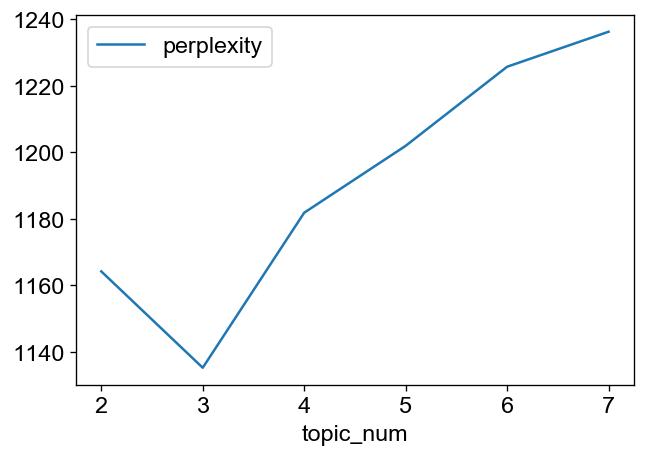

In [34]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

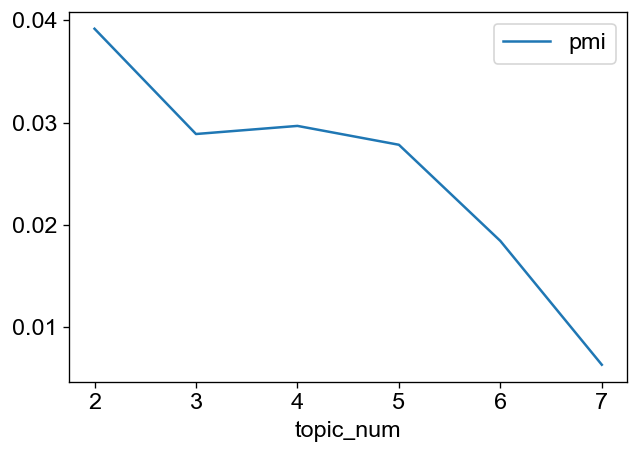

In [35]:
result.plot.line(x='topic_num', y='pmi')

ÂæûË®ìÁ∑¥ÁµêÊûú‰æÜÁúãÔºåÊàñÁôºÁèæperplexityÂú® 3 ÊúÄÂ•ΩÔºåËÄåpmiÂâáÊòØ2Êàñ3ËºÉ‰Ω≥ÔºåÊïÖ‰ª•‰∏ãbest_modelÂª∫Á´ãÂ∞áÈÅ∏Êìá3‰ΩúÁÇ∫num_topics

In [36]:
#Êú¨Â∞èÁµÑ‰æù‰ª•‰∏äÁµêÊûúÔºåÈÅ∏Êìánum_topicsÁÇ∫3
best_model = LdaModel(
    corpus = corpus,
    num_topics = 3,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # Ë®ìÁ∑¥Ê¨°Êï∏
    )

2024-05-05 23:12:56,470 : INFO : using symmetric alpha at 0.3333333333333333
2024-05-05 23:12:56,473 : INFO : using symmetric eta at 0.3333333333333333
2024-05-05 23:12:56,477 : INFO : using serial LDA version on this node
2024-05-05 23:12:56,479 : INFO : running online (multi-pass) LDA training, 3 topics, 5 passes over the supplied corpus of 1249 documents, updating model once every 1249 documents, evaluating perplexity every 1249 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-05 23:12:56,480 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-05 23:12:56,825 : INFO : -8.458 per-word bound, 351.6 perplexity estimate based on a held-out corpus of 1249 documents with 72807 words
2024-05-05 23:12:56,826 : INFO : PROGRESS: pass 0, at document #1249/1249
2024-05-05 23:12:57,084 : INFO : topic #0 (0.333): 0.010*"Ë¶∫Âæó" + 0.009*"ÊØîËºÉ" + 0.009*"ÊïôÊéà" + 0.007*"ÁúüÁöÑ" + 0.00

In [37]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.149368 -0.026233       1        1  44.368546
0      0.150792 -0.025497       2        1  38.871897
1     -0.001424  0.051731       3        1  16.759557, topic_info=     Term        Freq       Total Category  logprob  loglift
19     ÂñúÊ≠°  705.000000  705.000000  Default  30.0000  30.0000
2686   ÊïôÊéà  341.000000  341.000000  Default  29.0000  29.0000
107    ‰∏äË°£  492.000000  492.000000  Default  28.0000  28.0000
22     Â§ñÂ•ó  455.000000  455.000000  Default  27.0000  27.0000
44     Êê≠ÈÖç  514.000000  514.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
372    Â•ΩÁúã   41.601991  217.671860   Topic3  -5.6812   0.1314
352    ÁôºÁèæ   38.177433  147.711602   Topic3  -5.7671   0.4332
217    ÂïèÈ°å   41.975393  260.076819   Topic3  -5.6723  -0.0377
107    ‰∏äË°£   40.516425  492.039672   Topic3  -5.7077  -0.7107
238    ÊúÄËøë   39.308442  314.909866   Topic3  -5.7379  -0.2946

[238 rows x 6 columns], token_table=      Topic      Freq Term
term                      
466       1  0.307608   ‰∏Ä‰∏ã
466       2  0.502677   ‰∏Ä‰∏ã
466       3  0.191317   ‰∏Ä‰∏ã
0         1  0.385935   ‰∏Ä‰∫õ
0         2  0.482419   ‰∏Ä‰∫õ
...     ...       ...  ...
677       2  0.014491   È´òÈ†ò
677       3  0.028982   È´òÈ†ò
193       1  0.944505   ÈªëËâ≤
193       2  0.017173   ÈªëËâ≤
193       3  0.040070   ÈªëËâ≤

[528 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [42]:
#Â∞á‰∏ªÈ°åÊîπÊàê5ÁúãÁúãÂ∑ÆÁï∞
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 5,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # Ë®ìÁ∑¥Ê¨°Êï∏
    )

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2024-05-05 23:16:45,131 : INFO : using symmetric alpha at 0.2
2024-05-05 23:16:45,135 : INFO : using symmetric eta at 0.2
2024-05-05 23:16:45,138 : INFO : using serial LDA version on this node
2024-05-05 23:16:45,141 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 1249 documents, updating model once every 1249 documents, evaluating perplexity every 1249 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-05 23:16:45,143 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-05 23:16:45,455 : INFO : -8.624 per-word bound, 394.4 perplexity estimate based on a held-out corpus of 1249 documents with 72807 words
2024-05-05 23:16:45,455 : INFO : PROGRESS: pass 0, at document #1249/1249
2024-05-05 23:16:45,682 : INFO : topic #0 (0.200): 0.012*"ÊïôÊéà" + 0.011*"ÊØîËºÉ" + 0.009*"Ë¶∫Âæó" + 0.006*"ÁúüÁöÑ" + 0.006*"ÊúãÂèã" + 0.006*"ÁõÆÂâç" + 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.160542  0.017156       1        1  32.436314
0      0.185067 -0.044149       2        1  31.818692
2     -0.081750 -0.066486       3        1  13.526568
1      0.058346  0.094075       4        1  13.254582
4     -0.001121 -0.000596       5        1   8.963844, topic_info=     Term        Freq       Total Category  logprob  loglift
2686   ÊïôÊéà  358.000000  358.000000  Default  30.0000  30.0000
107    ‰∏äË°£  488.000000  488.000000  Default  29.0000  29.0000
44     Êê≠ÈÖç  513.000000  513.000000  Default  28.0000  28.0000
1600   Èù¢Ë©¶  159.000000  159.000000  Default  27.0000  27.0000
22     Â§ñÂ•ó  452.000000  452.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
203    ‰πãÂâç   22.826612  148.458934   Topic5  -5.6557   0.5396
269    ÈÄôÊ¨°   23.978255  236.667637   Topic5  -5.6064   0.1225
64     ÁúüÁöÑ   27.052782  663.070255   Topic5  -5.4858  -0.7871
2      ‰∏ÄÈªû   23.986214  247.805763   Topic5  -5.6061   0.0768
91     ÈÅ©Âêà   23.241641  260.121910   Topic5  -5.6377  -0.0032

[389 rows x 6 columns], token_table=      Topic      Freq Term
term                      
466       1  0.159567   ‰∏Ä‰∏ã
466       2  0.398918   ‰∏Ä‰∏ã
466       3  0.132973   ‰∏Ä‰∏ã
466       4  0.178563   ‰∏Ä‰∏ã
466       5  0.129174   ‰∏Ä‰∏ã
...     ...       ...  ...
193       1  0.727078   ÈªëËâ≤
193       2  0.011633   ÈªëËâ≤
193       3  0.186132   ÈªëËâ≤
193       4  0.023267   ÈªëËâ≤
193       5  0.058166   ÈªëËâ≤

[1107 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2, 5])

In [ ]:
#pyLDAvis.save_html(p, "lda_zh.html")

Âæû‰∏äÈù¢ÂÖ©ÂºµÂúñÂèØÁúãÂá∫Ëã•‰ª•Topic 3ÁÇ∫‰æã‰æÜÂÅöÊØîËºÉÔºö

Ë®≠ÂÆö3ÂÄã‰∏ªÈ°åÁöÑ Top-30 Most Relevant Terms for Topic 3 ÁÇ∫ 16.8%Ôºå Ë®≠ÂÆö5ÂÄã‰∏ªÈ°åÁöÑ Top-30 Most Relevant Terms for Topic 3 ÁÇ∫ 13.5%Ôºå

‰ª•Ê≠§ÂèØÁü•3ÂÄã‰∏ªÈ°åÁöÑRelevant Terms‰æÜÂæóÊõ¥Â•Ω„ÄÇ


# 4.GuidedLDA

LDA‰ΩúÁÇ∫Áï∂Ââç‰∏ªÊµÅÁöÑ‰∏ªÈ°åÊ®°ÂûãÁÆóÊ≥ï‰πã‰∏ÄÔºåÂèØÂø´ÈÄüÂú∞Ê¶ÇÊã¨Â§ßÈáèÂ∞çË©±ÁöÑ‰∏ªË¶ÅÂÖßÂÆπÔºå
‰ΩÜÊòØÂú®Êüê‰∫õ‰∏ªÈ°åÈóúÈçµË©ûÁöÑÊèèËø∞‰∏ä‰∏¶‰∏çÊòØÁâπÂà•ÁöÑÊ∫ñÁ¢∫ÔºåÂ§öÂÄã‰∏ªÈ°å‰πãÈñìÂÆπÊòìÁî¢Áîü‰∫§Âèâ‰ª•ÂèäÂÆπÊòìÂá∫ÁèæË©±È°åÁÑ°ÈóúÁöÑÈóúÈçµË©û„ÄÇ

GuidedLDA ÊòØÂèØÈÅ∏ÂçäÁõ£Áù£‰∏ªÈ°åË≠òÂà•ÁÆóÊ≥ïÔºåÊâÄË¨Ç‚ÄúÂèØÈÅ∏‚ÄùÊòØÊåáÔºåÂèØ‰ª•ÊèêÂâçË®≠ÁΩÆ‰∏ªÈ°åÁöÑÁ®ÆÂ≠êË©û
ÂÜçÂ∞áÂæåÊúâÈÅ∏ÊìáÁöÑÊääËá™ÂÆöÁæ©ÁöÑ‰∏ªÈ°åÂÇ≥ÂÖ•Ê®°Âûã‰∏≠Ôºå ÈÄöÈÅéË®≠ÁΩÆÁ®ÆÂ≠êË©ûÔºåÂºïÂ∞éÁÆóÊ≥ïÊúùÈ†êË®≠ÁöÑË©±È°åÊñπÂêëÂåØÈõÜÔºåÈÅîÂà∞Ë©±È°åÂçäÁõ£Áù£ÁöÑÁõÆÁöÑ„ÄÇ




In [116]:
#ÂÆâË£ùGuidedLDA
#pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA

  Cloning https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git to /private/var/folders/ng/25l3_vws2cl593j20n75bcy00000gn/T/pip-install-dluzvdey/guidedlda_54d6d21c8913453392fd58032417192c
  Running command git clone --filter=blob:none --quiet https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git /private/var/folders/ng/25l3_vws2cl593j20n75bcy00000gn/T/pip-install-dluzvdey/guidedlda_54d6d21c8913453392fd58032417192c
  Resolved https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git to commit 05c3bf2c18f9d126cc5170256f33e6c1fbc90052
  Preparing metadata (setup.py) ... done
  Created wheel for GuidedLDA: filename=guidedlda-2.0.0.dev31-cp39-cp39-macosx_11_0_arm64.whl size=2305258 sha256=6d6fb9bda7d0b1af211d48f8ae173f2cc1d005190544af279f0aea0abbf2b50b
  Stored in directory: /private/var/folders/ng/25l3_vws2cl593j20n75bcy00000gn/T/pip-ephem-wheel-cache-ejcmfpdn/wheels/a0/96/f9/fffcece983647506ae73b361b4c72452442916cc1f7a856c1d
Successfully built GuidedLDA
Note: you may n

In [43]:
import guidedlda
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('‰∏Ä‰∫õ', '‰∏ÄËµ∑', '‰∏ÄÈªû', '‰∏ãÂéª', '‰∏çÂà∞', '‰πæÊ∑®', 'ÂÅ¥ÈÇä', 'ÂÖ®Ë∫´', 'Âá∏È°Ø', 'Âá∫ÂéªÁé©')

In [44]:
word2id = dictionary.token2id

In [45]:
#Ëá™Ë°åË®≠ÂÆöÁ®ÆÂ≠êÂ≠óË©û
seed_topic_list = [
    ["Êê≠ÈÖç", "È¢®Ê†º", "Ë°£Êúç", "ÈÄ†Âûã", "ÊùêË≥™"],
    ["ÈÅãÂã¢", "Ê∞¥Áì∂", "Âê∏Âºï", "ËôïÂ•≥Â∫ß", "ÊõñÊòß"],
    ["Âà©Áéá", "ËÇ°Á•®", "‰ø°Ë≤∏", "‰ø°Áî®Âç°", "ÂÑ≤ËìÑ"],
    ["ÊïôÊéà", "ÈåÑÂèñ", "ÂØ¶È©óÂÆ§", "‰∏≠Â±±", "ËÉåÊôØ"]
]

In [46]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [47]:
# guidedlda ÈúÄË¶Å DTM Ê†ºÂºè‰ΩúÁÇ∫ inputÔºåÂõ†Ê≠§ÈÄôÈÇäÂà©Áî® corpus2dense() ÊñπÊ≥ïÈÄ≤Ë°åËΩâÊèõ
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-05-05 23:18:01,329 : INFO : n_documents: 1249
2024-05-05 23:18:01,330 : INFO : vocab_size: 2785
2024-05-05 23:18:01,330 : INFO : n_words: 72807
2024-05-05 23:18:01,331 : INFO : n_topics: 5
2024-05-05 23:18:01,331 : INFO : n_iter: 100
2024-05-05 23:18:01,334 : WARNING : all zero row in document-term matrix found
2024-05-05 23:18:01,588 : INFO : <0> log likelihood: -709582
2024-05-05 23:18:01,663 : INFO : <20> log likelihood: -531754
2024-05-05 23:18:01,737 : INFO : <40> log likelihood: -526408
2024-05-05 23:18:01,810 : INFO : <60> log likelihood: -524574
2024-05-05 23:18:01,883 : INFO : <80> log likelihood: -523252
2024-05-05 23:18:01,956 : INFO : <99> log likelihood: -521773


In [48]:
# Êï¥ÁêÜÔºèÈ°ØÁ§∫‰∏ªÈ°åÊ®°ÂûãÁµêÊûú
#n_top_words = 10
n_top_words = 5
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    #ÂàóÂá∫ÊØèÂÄã‰∏ªÈ°åÁöÑÂ∏∏Áî®Â≠óË©û
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: ÂñúÊ≠° Êê≠ÈÖç ‰∏äË°£ Â§ñÂ•ó ÂàÜ‰∫´
Topic 1: ÊúãÂèã Ë¶∫Âæó ÂñúÊ≠° ÁúüÁöÑ Áü•ÈÅì
Topic 2: ÊäïË≥á ÁõÆÂâç Âà©Áéá ËÇ°Á•® Ë≤∏Ê¨æ
Topic 3: ÊïôÊéà ËÄÅÂ∏´ Ë´ãÂïè Èù¢Ë©¶ ÊØîËºÉ
Topic 4: ÂàÜ‰∫´ ÊúÄÂæå ÁúãÂà∞ ÊôÇÈñì ÈúÄË¶Å


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.329815 -0.029092       1        1  38.412623
4     -0.075831  0.303325       2        1  20.216016
3     -0.135272  0.009728       3        1  14.479482
1      0.080443 -0.080972       4        1  13.543560
2     -0.199154 -0.202988       5        1  13.348320, topic_info=     Term        Freq       Total Category  logprob  loglift
2686   ÊïôÊéà  354.000000  354.000000  Default  30.0000  30.0000
2044   ÊäïË≥á  243.000000  243.000000  Default  29.0000  29.0000
107    ‰∏äË°£  494.000000  494.000000  Default  28.0000  28.0000
19     ÂñúÊ≠°  728.000000  728.000000  Default  27.0000  27.0000
44     Êê≠ÈÖç  518.000000  518.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
50     ÊØîËºÉ   75.804556  597.914605   Topic5  -4.8536  -0.0515
358    Ë´ãÂïè   56.855911  260.327409   Topic5  -5.1413   0.4924
238    ÊúÄËøë   48.877533  322.479447   Topic5  -5.2925   0.1271
115    Âª∫Ë≠∞   46.882939  173.641425   Topic5  -5.3341   0.7044
614    ÊØèÂÄã   44.888345   92.830741   Topic5  -5.3776   1.2872

[307 rows x 6 columns], token_table=      Topic      Freq Term
term                      
466       1  0.263124   ‰∏Ä‰∏ã
466       2  0.115342   ‰∏Ä‰∏ã
466       3  0.331608   ‰∏Ä‰∏ã
466       4  0.209057   ‰∏Ä‰∏ã
466       5  0.082902   ‰∏Ä‰∏ã
...     ...       ...  ...
142       2  0.016409   È¢®Ê†º
142       3  0.060167   È¢®Ê†º
2167      4  0.062603   È¢®Èö™
2167      5  0.939041   È¢®Èö™
193       1  1.000813   ÈªëËâ≤

[472 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 2, 3])

‰ª•‰∏ãÁÇ∫Â∞á‰∏ªÈ°åÁöÑÂ≠óË©ûÂèäÂ≠óË©ûÂá∫ÁèæÊ¨°Êï∏ÔºåÂ≠òÊàê‰∏çÂêåÁöÑcsvÊ™î

In [51]:
dcard_df.loc[dcard_df['artCatagory']=='Á©øÊê≠', "words"].to_csv("./2024_study_group9_3/words.csv")
dcard_df.loc[dcard_df['artCatagory']=='ÁêÜË≤°', "words"].to_csv("./2024_study_group9_3/words_fin.csv")

In [52]:
dcard_df.loc[dcard_df['artCatagory']=='Á©øÊê≠', "words"].explode().value_counts().to_csv("./2024_study_group9_3/words_count.csv")
dcard_df.loc[dcard_df['artCatagory']=='ÁêÜË≤°', "words"].explode().value_counts().to_csv("./2024_study_group9_3/words_count_fin.csv")

# 5.‰∏ªÈ°åÂàÜ‰ΩàÁöÑÊáâÁî®ÔºåÊê≠ÈÖçÂÖ∂‰ªñÊñáÁ´†Ë≥áË®ä

In [54]:
# ÂèñÂæóÊØèÊ¢ùPOÊñáÁöÑ‰∏ªÈ°åÂàÜ‰ΩàÔºå‰ª•model_5Ê®°Âûã‰æÜÊâæÂá∫‰∏ªÈ°å
topics_doc = model_5.get_document_topics(corpus)

In [55]:
topics_doc[100]

[(0, 0.023165436),
 (1, 0.022770187),
 (2, 0.9086551),
 (3, 0.022617752),
 (4, 0.02279154)]

In [56]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.        , 0.        , 0.        , 0.99457639, 0.        ],
       [0.        , 0.        , 0.771106  , 0.21935941, 0.        ],
       [0.        , 0.        , 0.64554709, 0.34908393, 0.        ],
       ...,
       [0.91743213, 0.07102628, 0.        , 0.        , 0.        ],
       [0.07912164, 0.91750115, 0.        , 0.        , 0.        ],
       [0.95187998, 0.01207378, 0.01203546, 0.01196264, 0.01204818]])

In [57]:
#ËÆìtopic_labelÂæû 0~4 ÊîπÊàê1~5
dcard_df['topic_label'] = m_theta.argmax(axis=1) + 1
dcard_df['topic_label']

0       4
1       3
4       3
6       4
7       3
       ..
3588    1
3590    1
3591    1
3592    2
3594    1
Name: topic_label, Length: 1249, dtype: int64

In [58]:
#ÂàóÂá∫topic_labelÂÄºÁöÑÊ¨°Êï∏
dcard_df['topic_label'].value_counts()

topic_label
1    605
4    233
2    150
5    134
3    127
Name: count, dtype: int64

In [59]:
dcard_df.head()

content  \
0  Â§ßÂÆ∂Â•ΩÊàëÊòØË∫´È´òÈ´îÈáçÂæàÂñúÊ≠°Ë£ôË£ùÊâÄ‰ª•Ë°£Ê´ÉË£°Âπæ‰πéÊâæ‰∏çÂà∞Ë§≤Â≠êÁÖßÁâáÈÉΩÊòØÂá∫ÂéªÁé©ÊôÇÊãçÁöÑ‰∏çÈÅéÊòØÂá∫ÈÅäÈ†Ü‰æøÊãçÁöÑ‰∏ç...   
1  È∫µÂåÖË∂Ö‰∫∫Âõ†ÁÇ∫Êú¨Ë∫´Èï∑Áõ∏ÁÑ°ÂÑ™Âã¢ÊâÄ‰ª•Ê±∫ÂÆöÁî®È∫µÂåÖË∂Ö‰∫∫ÁöÑÂûãÊÖãÂá∫Â†¥Á™ÆË∂Ö‰∫∫Êú¨‰∫∫ÁúüÁöÑÂ•ΩÊÉ≥Áç≤ÂæóË≥ºÁâ©ÈáëÁ¨¨‰∏ÄÂ•óÊòØ‰ºë...   
4  ÂìàÂõâÂ§ßÂÆ∂Â•Ω‰πÖ‰∏çË¶ãÁ´üÁÑ∂Èöî‰∫ÜÂÖ©Âπ¥È¢®Ê†ºË∑ü‰ª•ÂâçÂ•ΩÂÉèËΩâËÆäË†ªÂ§ßÁöÑÁèæÂú®ÈÉΩÁ©øÊ∑±Ëâ≤Á≥ªÁÇ∫‰∏ªÁ∞°ÂñÆÂèàÊê≠ÂïäË∫´È´òÈ´îÈáçÈÇÑÊòØ...   
6  Âó®Âó®ÊàëÊòØÂØßÈÄôÊ¨°ÊÉ≥‰æÜÂíåÂ§ßÂÆ∂ÂàÜ‰∫´ÊàëÊúÄËøëÊñ∞ÂÖ•ÊâãÁöÑÊó•ÁâåÊ¥ãË£ùÂÄëÊûúÁÑ∂Â∞èÈöªÂ•≥Â≠©Ë≤∑Êó•ÁâåÂ∞±ÊòØ‰∏çÊúÉÈåØÈï∑Â∫¶ÈÉΩÊúÉÂæàÂâõ...   
7  ÂìàÂõâÂ§ßÂÆ∂Â•ΩÊàëÊòØËçâËéìÂ•∂ÊòîÂπ≥Â∏∏ÈÉΩÂú®ÁæéÂ¶ùÁâàÂá∫Ê≤íÁöÑÊàë‰ªäÂ§©Ë¶Å‰æÜÂàÜ‰∫´Â•óÂèØÁîúÂèØÈππÁöÑÁ©øÊê≠ÊúâËààË∂£ÁöÑÂ∞±‰∏ÄËµ∑Áúã‰∏ãÂéª...   

                                       artUrl artCatagory  \
0  https://www.dcard.tw/f/dressup/p/255078442          Á©øÊê≠   
1  https://www.dcard.tw/f/dressup/p/255078768          Á©øÊê≠   
4  https://www.dcard.tw/f/dressup/p/255065394          Á©øÊê≠   
6  https://www.dcard.tw/f/dressup/p/255047494          Á©øÊê≠   
7  https://www.dcard.tw/f/dressup/p/255065466          Á©øÊê≠   

               artDate                                              words  \
0  2024-03-25 16:18:42  [Ë∫´È´òÈ´îÈáç, ÂñúÊ≠°, Ë£ôË£ù, Ë°£Ê´É, ‰∏çÂà∞, Ë§≤Â≠ê, ÁÖßÁâá, Âá∫ÂéªÁé©, Âá∫ÈÅä, È†Ü‰æø, Â∞àÊ•≠...   
1  2024-03-25 16:54:35  [Ë∂Ö‰∫∫, Èï∑Áõ∏, ÂÑ™Âã¢, Ê±∫ÂÆö, Ë∂Ö‰∫∫, ÂûãÊÖã, Âá∫Â†¥, Ë∂Ö‰∫∫, ÁúüÁöÑ, Áç≤Âæó, Ë≥ºÁâ©, Á¨¨...   
4  2024-03-24 10:59:45  [ÂìàÂõâ, Â•Ω‰πÖ‰∏çË¶ã, ÂÖ©Âπ¥, È¢®Ê†º, ‰ª•Ââç, Â•ΩÂÉè, ËΩâËÆä, Ë†ªÂ§ß, ÁèæÂú®, Ê∑±Ëâ≤, Á≥ªÁÇ∫,...   
6  2024-03-22 10:00:10  [ÊòØÂØß, ÈÄôÊ¨°, ÊÉ≥‰æÜ, ÂàÜ‰∫´, ÊúÄËøë, ÂÖ•Êâã, Êó•Áâå, Ê¥ãË£ù, Â•≥Â≠©, Ë≤∑Êó•Áâå, ‰∏çÊúÉÈåØ,...   
7  2024-03-24 11:08:57  [ÂìàÂõâ, ËçâËéì, Â•∂Êòî, Âπ≥Â∏∏, ÁæéÂ¶ùÁâà, Âá∫Ê≤í, ‰ªäÂ§©, Ë¶Å‰æÜ, ÂàÜ‰∫´, ËààË∂£, ‰∏ÄËµ∑, ...   

   topic_label  
0            4  
1            3  
4            3  
6            4  
7            3

In [60]:
#Â∞áartDateÈÄ≤Ë°åÊôÇÈñìÊ†ºÂºèËΩâÊèõ
dcard_df['artDate'] = pd.to_datetime(dcard_df['artDate'])
dcard_df['artDate']

0      2024-03-25 16:18:42
1      2024-03-25 16:54:35
4      2024-03-24 10:59:45
6      2024-03-22 10:00:10
7      2024-03-24 11:08:57
               ...        
3588   2024-03-01 12:00:12
3590   2024-03-03 11:16:03
3591   2024-03-01 11:01:16
3592   2024-03-03 13:10:51
3594   2024-03-03 22:40:19
Name: artDate, Length: 1249, dtype: datetime64[ns]

In [61]:
dcard_df['artDate'].dt.date

0       2024-03-25
1       2024-03-25
4       2024-03-24
6       2024-03-22
7       2024-03-24
           ...    
3588    2024-03-01
3590    2024-03-03
3591    2024-03-01
3592    2024-03-03
3594    2024-03-03
Name: artDate, Length: 1249, dtype: object

In [62]:
#ÈÄèÈÅégroupbyÂêà‰ΩµÊó•ÊúüÔºåÂàóÂá∫Ë≥áÊñôÈõÜ‰∏≠2024-03-01 Âà∞ 2024-03-25 ÊØèÊó•‰∏çÂêå‰∏ªÈ°åÁöÑÊØîÁéá
dcard_df.groupby(dcard_df['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2024-03-01  1              0.724409
            4              0.118110
            5              0.062992
            2              0.055118
            3              0.039370
                             ...   
2024-03-25  4              0.550000
            3              0.300000
            1              0.050000
            2              0.050000
            5              0.050000
Name: proportion, Length: 113, dtype: float64

In [63]:
date_topic = dcard_df.groupby(dcard_df['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label         1         2         3         4         5
artDate                                                      
2024-03-01   0.724409  0.055118  0.039370  0.118110  0.062992
2024-03-02   0.647887  0.126761  0.014085  0.084507  0.126761
2024-03-03   0.621951  0.109756  0.109756  0.048780  0.109756
2024-03-04   0.588889  0.100000  0.055556  0.144444  0.111111
2024-03-05   0.642857  0.157143  0.057143  0.114286  0.028571

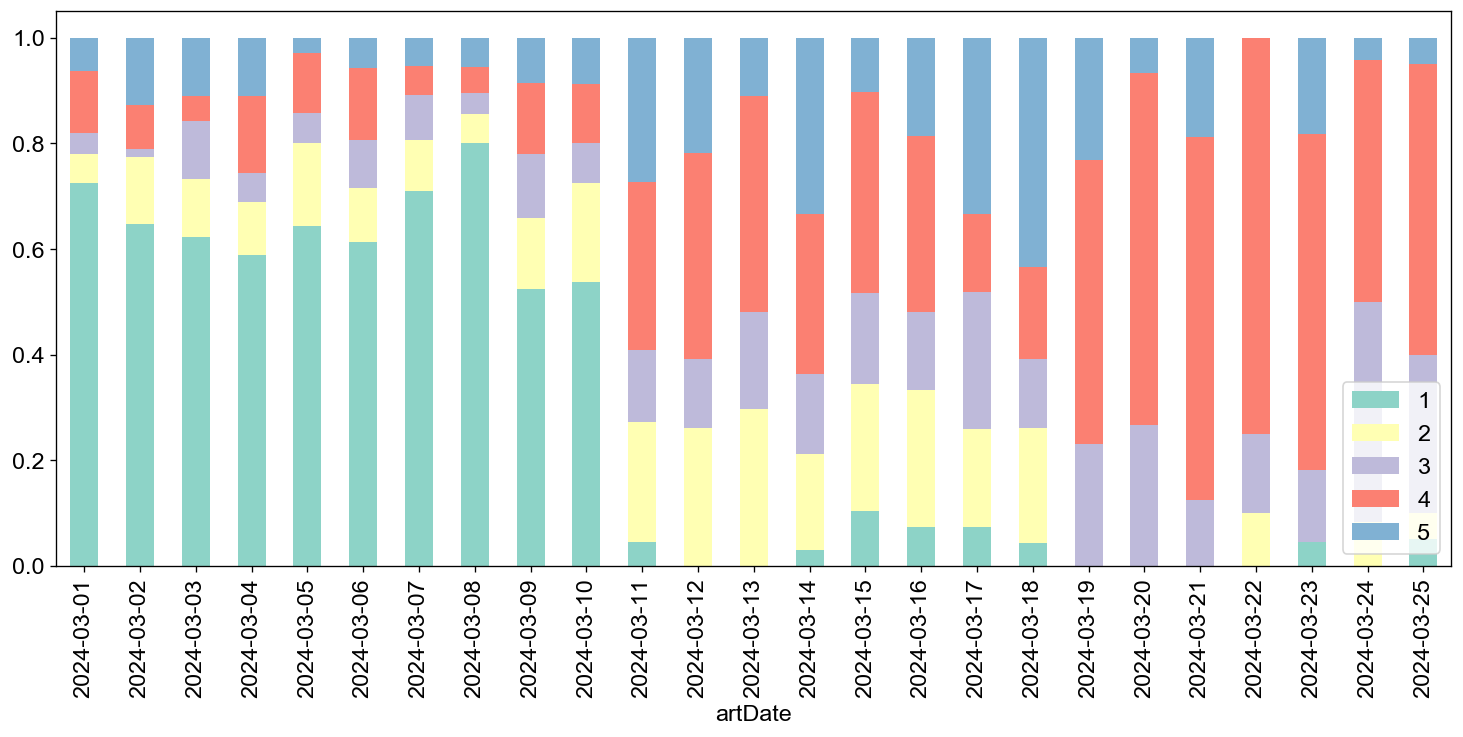

In [64]:
#Êê≠ÈÖçÊñáÁ´†‰∏≠ÁöÑÊó•ÊúüË≥áË®äË≥áË®ä‰æÜÁµêÂêà‰∏ªÈ°åÂàÜ‰ΩàÁµêÊûúÈÄ≤Ë°åÁπ™Âúñ
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

Ê≠§ÂúñÁµêÊûúÁÇ∫ÈÄèÈÅé‰∏ªÈ°åÊ®°ÂûãËàáÊó•ÊúüÁöÑÁµêÂêàÈÅãÁî®Ê°à‰æãÔºåÂæû‰∏äÈù¢model_5Ê®°ÂûãÁöÑÂúñÂΩ¢Â∞±ÂèØÁúãÂá∫topic1ÊòØÁ©øÊê≠ÁâàÔºå

‰∏ªÈ°å1 Âú® 3/1-3/10 Ë¢´Ë®éË´ñÁöÑÊØî‰æãÂæàÈ´òÔºåÂæàÂ§ßÂéüÂõ†ÂèØËÉΩÊòØÁï∂ÊôÇÊ≠£ÂÄºÈñãÂ≠∏ÊôÇÊúüÔºå‰∫ãÊÉÖËºÉÂ∞ë‰∏îÊúâÂæàÂ§öÊ¥ªÂãïÔºå

ÂÉèÊòØÁ§æÂúòÊàñÁ≥ª‰∏äÂèØËÉΩÈÉΩÊúâÔºåÂõ†Ê≠§Âá∫ÈñÄÁ©øÊê≠Â∞±È°ØÂæóÊ•µÁÇ∫ÈáçË¶ÅÔºåÂõ†Ê≠§Âú®Ê≠§ÊôÇÊúüÂª£ÂèóÂ≠∏ÁîüË®éË´ñ„ÄÇ

ÂèØ‰ª•ÈÄèÈÅéÊê≠ÈÖçÊñáÁ´†ÁöÑË≥áË®äÔºà‰æãÂ¶ÇÊó•ÊúüÁ≠âÔºâÔºåËÆì‰∏ªÈ°åÊ®°ÂûãÁöÑÁµêÊûúËÉΩÂÅöÂá∫Êõ¥Â§öÁöÑÂàÜÊûêÊáâÁî®Ôºå‰ª•Ê≠§‰æÜÂÅöÁÇ∫ÂæåÁ∫åÁ†îÁ©∂Êé¢Á¥¢ÁöÑÁõÆÊ®ô„ÄÇ